In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0


Cloning into 'yolov5'...
remote: Enumerating objects: 16003, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 16003 (delta 21), reused 20 (delta 13), pack-reused 15967
Receiving objects: 100% (16003/16003), 14.66 MiB | 17.72 MiB/s, done.
Resolving deltas: 100% (10987/10987), done.
/content/yolov5
HEAD is now at 064365d Update parse_opt() in export.py to work as in train.py (#10789)


In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.1 MB/s eta 0:00:00
Setup complete. Using torch 2.0.1+cu118 CPU


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="QsK90UUHzIAOlSrUEEy2")
project = rf.workspace("smartc").project("resume-parser-bchlq")
dataset = project.version(1).download("yolov5")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to resume-parser-1 in yolov5pytorch:: 100%|██████████| 8756/8756 [00:03<00:00, 2566.56it/s]


In [ ]:
%cat {dataset.location}/data.yaml

names:
- Achievement
- Certifications
- Community
- Contact
- Education
- Experience
- Interests
- Languages
- Name
- Profil
- Projects
- image
- resume
- skills
nc: 14
roboflow:
  license: CC BY 4.0
  project: resume-parser-bchlq
  url: https://universe.roboflow.com/smartc/resume-parser-bchlq/dataset/1
  version: 1
  workspace: smartc
test: ../test/images
train: resume-parser-1/train/images
val: resume-parser-1/valid/images


In [ ]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#this is the model configuration we will use for our tutorial
%cat /content/yolov5/models/yolov5s.yaml
anchors:

# This section defines the anchor boxes used for each feature map scale in the YOLOv5 model.
# Each line represents a set of anchor boxes for a specific feature map scale.
# The anchor boxes are defined as pairs of values, representing the width and height of the box.
# For example:
# [10, 13, 16, 30, 33, 23] represents the anchor boxes for the feature map scale P3/8.
# [30, 61, 62, 45, 59, 119] represents the anchor boxes for the feature map scale P4/16.
# [116, 90, 156, 198, 373, 326] represents the anchor boxes for the feature map scale P5/32.
# backbone:

# This section defines the backbone architecture of the YOLOv5 model.
# Each element in the list represents a module in the backbone.
# The format for each element is [from, number, module, args].
# from denotes the source feature map for the module.
# number denotes the number of times the module is repeated.
# module denotes the type of module used in the backbone, such as Conv, C3, or SPPF.
# args specifies the arguments for the module.
# For example:
# [-1, 1, Conv, [64, 6, 2, 2]] represents a Conv module with 64 output channels, a kernel size of 6, and a stride of 2, applied to the initial feature map.
# [-1, 3, C3, [128]] represents a C3 module with 128 filters, applied to the feature map obtained from the previous module.
# head:

# This section defines the head architecture of the YOLOv5 model.
# Similar to the backbone section, each element in the list represents a module in the head.
# The format for each element is [from, number, module, args].
# from denotes the source feature map for the module.
# number denotes the number of times the module is repeated.
# module denotes the type of module used in the head.
# args specifies the arguments for the module.
# Some additional elements in the head section are nested lists, which indicate concatenation of feature maps.
# For example:
# [-1, 1, Conv, [512, 1, 1]] represents a Conv module with 512 output channels and a kernel size of 1, applied to the feature map from the previous module.
# [[17, 20, 23], 1, Detect, [nc, anchors]] represents the final Detect module, which performs object detection using the feature maps from P3, P4, and P5, along with the specified anchor boxes.

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache


/content/yolov5
2023-09-30 06:55:07.653926: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-30 06:55:08.558260: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/content/yolov5/resume-parser-1/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_pe

In [ ]:
import os

# Specify the path
path = '/content/yolov5/runs/train/yolov5s_results/'

# Change the current working directory
os.chdir(path)

# List the files in the directory
files = os.listdir()
print(files)


['val_batch0_labels.jpg', 'opt.yaml', 'R_curve.png', 'val_batch1_pred.jpg', 'results.png', 'events.out.tfevents.1696056910.1cf55ba79d6b.3785.0', 'val_batch1_labels.jpg', 'train_batch2.jpg', 'val_batch2_pred.jpg', 'labels_correlogram.jpg', 'train_batch1.jpg', 'confusion_matrix.png', 'P_curve.png', 'train_batch0.jpg', 'val_batch0_pred.jpg', 'val_batch2_labels.jpg', 'weights', 'labels.jpg', 'results.csv', 'F1_curve.png', 'PR_curve.png', 'hyp.yaml']


In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir run
%reload_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 24910), started 0:03:43 ago. (Use '!kill 24910' to kill it.)

<IPython.core.display.Javascript object>

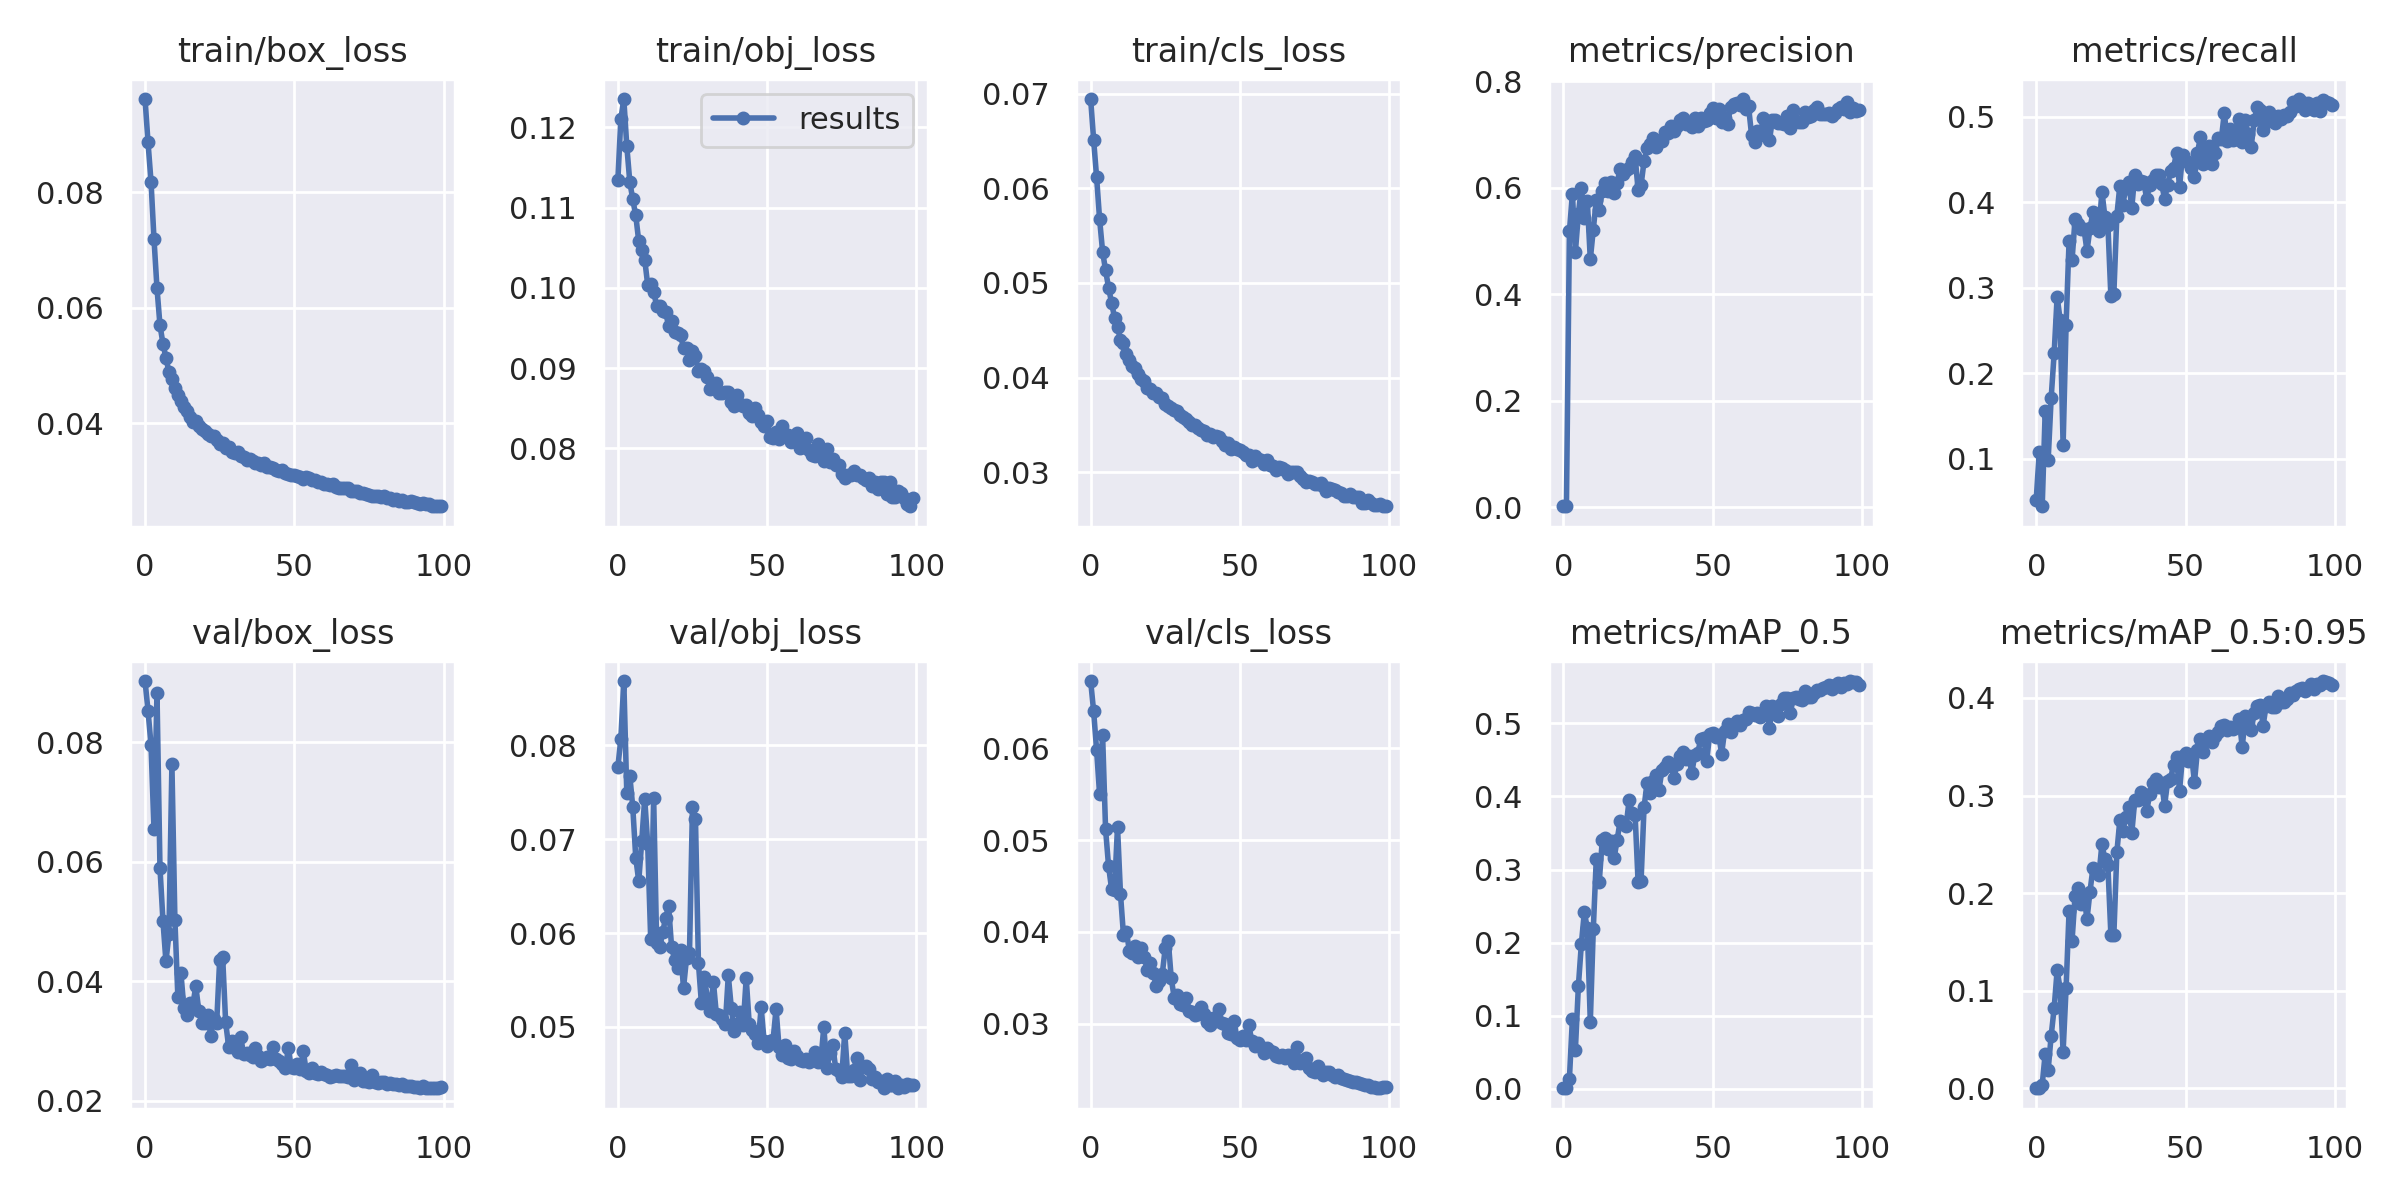

In [ ]:

 we can also output some older school graphs if the tensor board isn't working for whatever reason...
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png


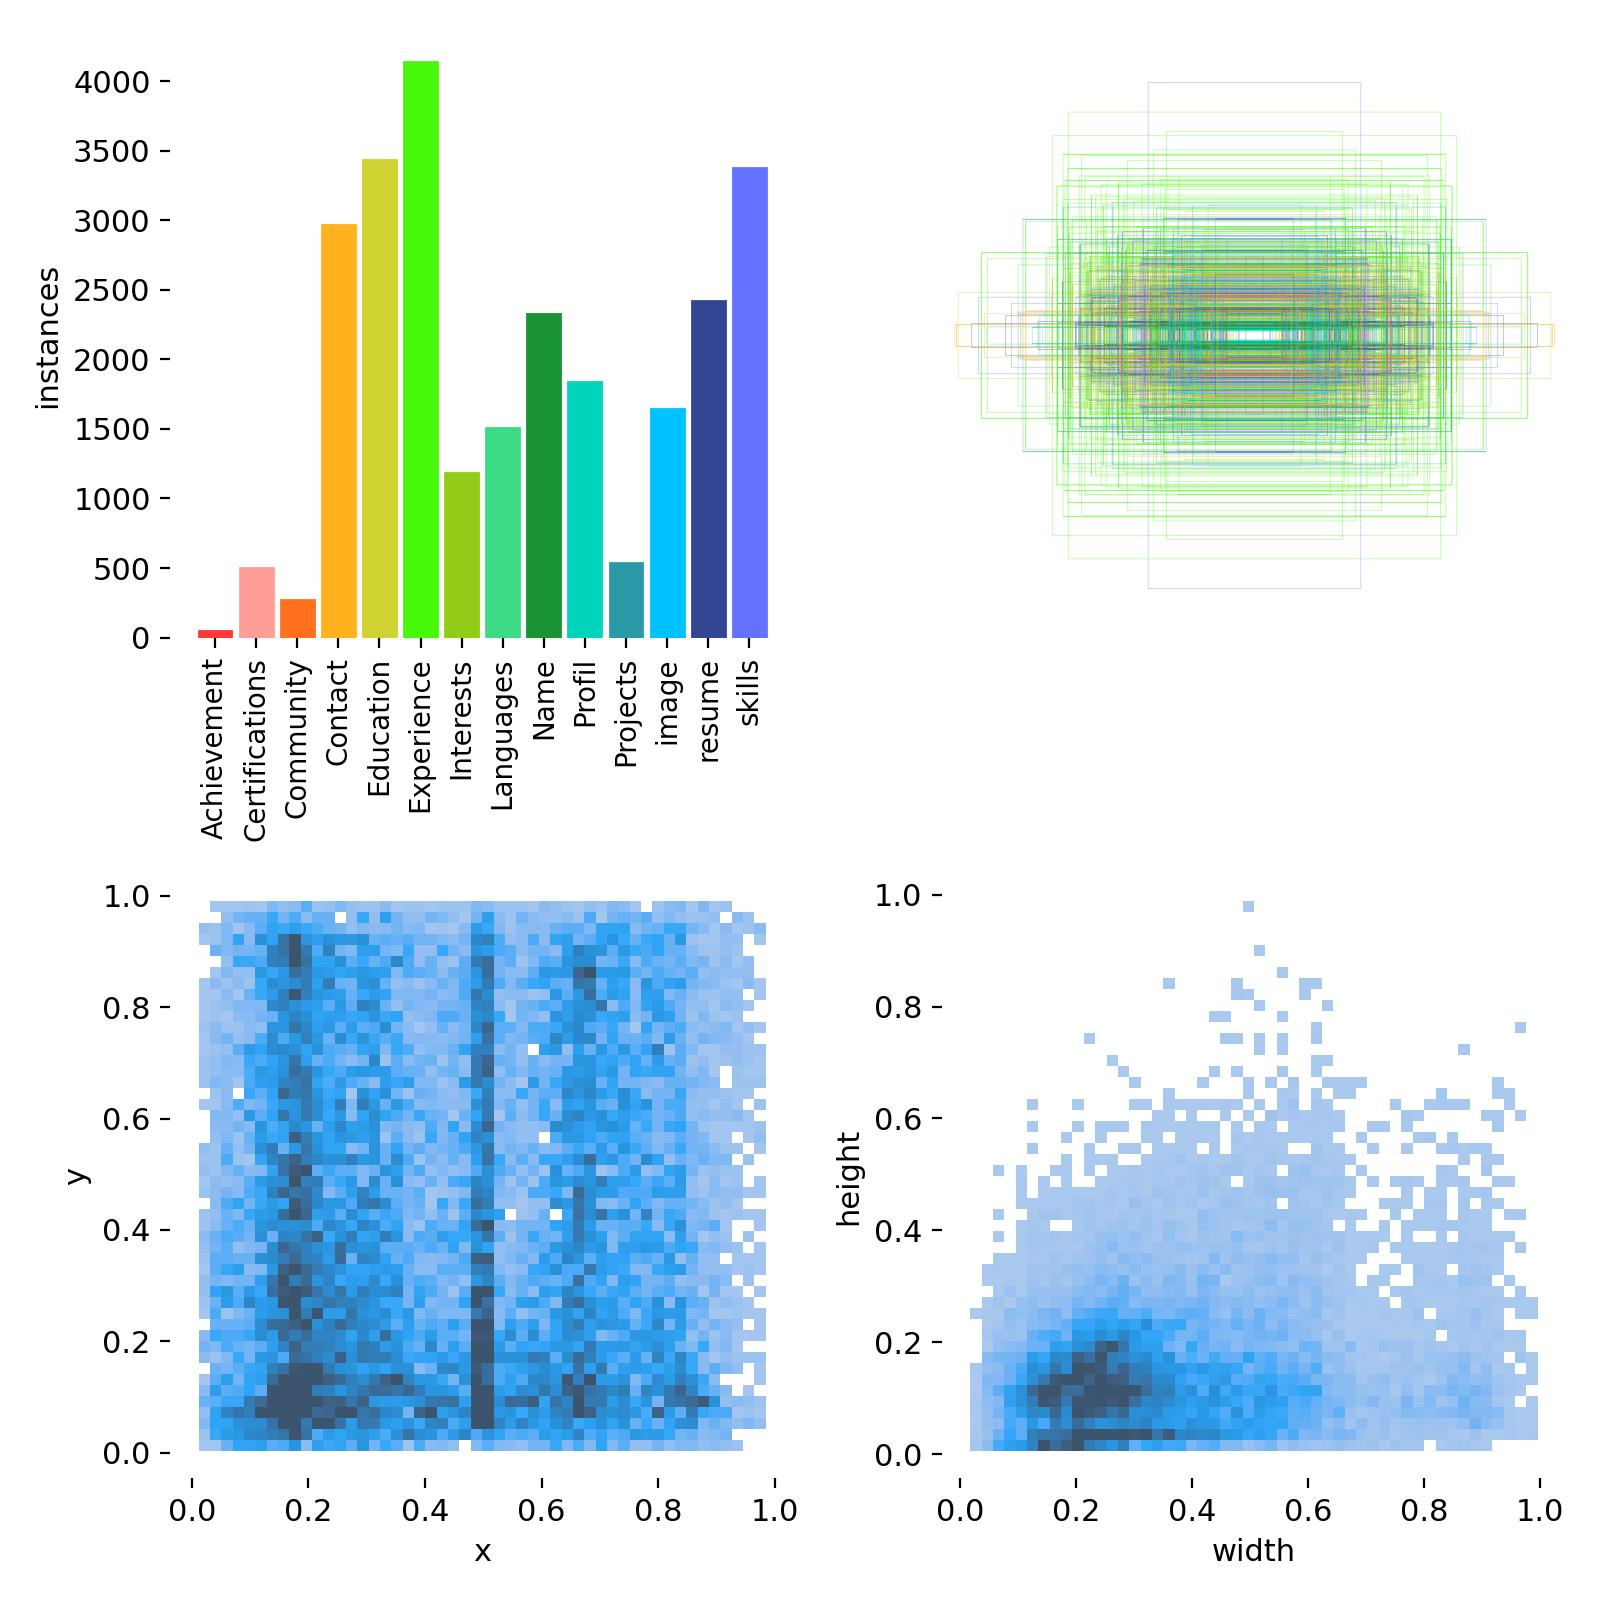

In [ ]:
from IPython.display import Image

# Specify the path to the labels image
labels_image_path = '/content/yolov5/runs/train/yolov5s_results/labels.jpg'

# Display the image
Image(filename=labels_image_path, width=900)


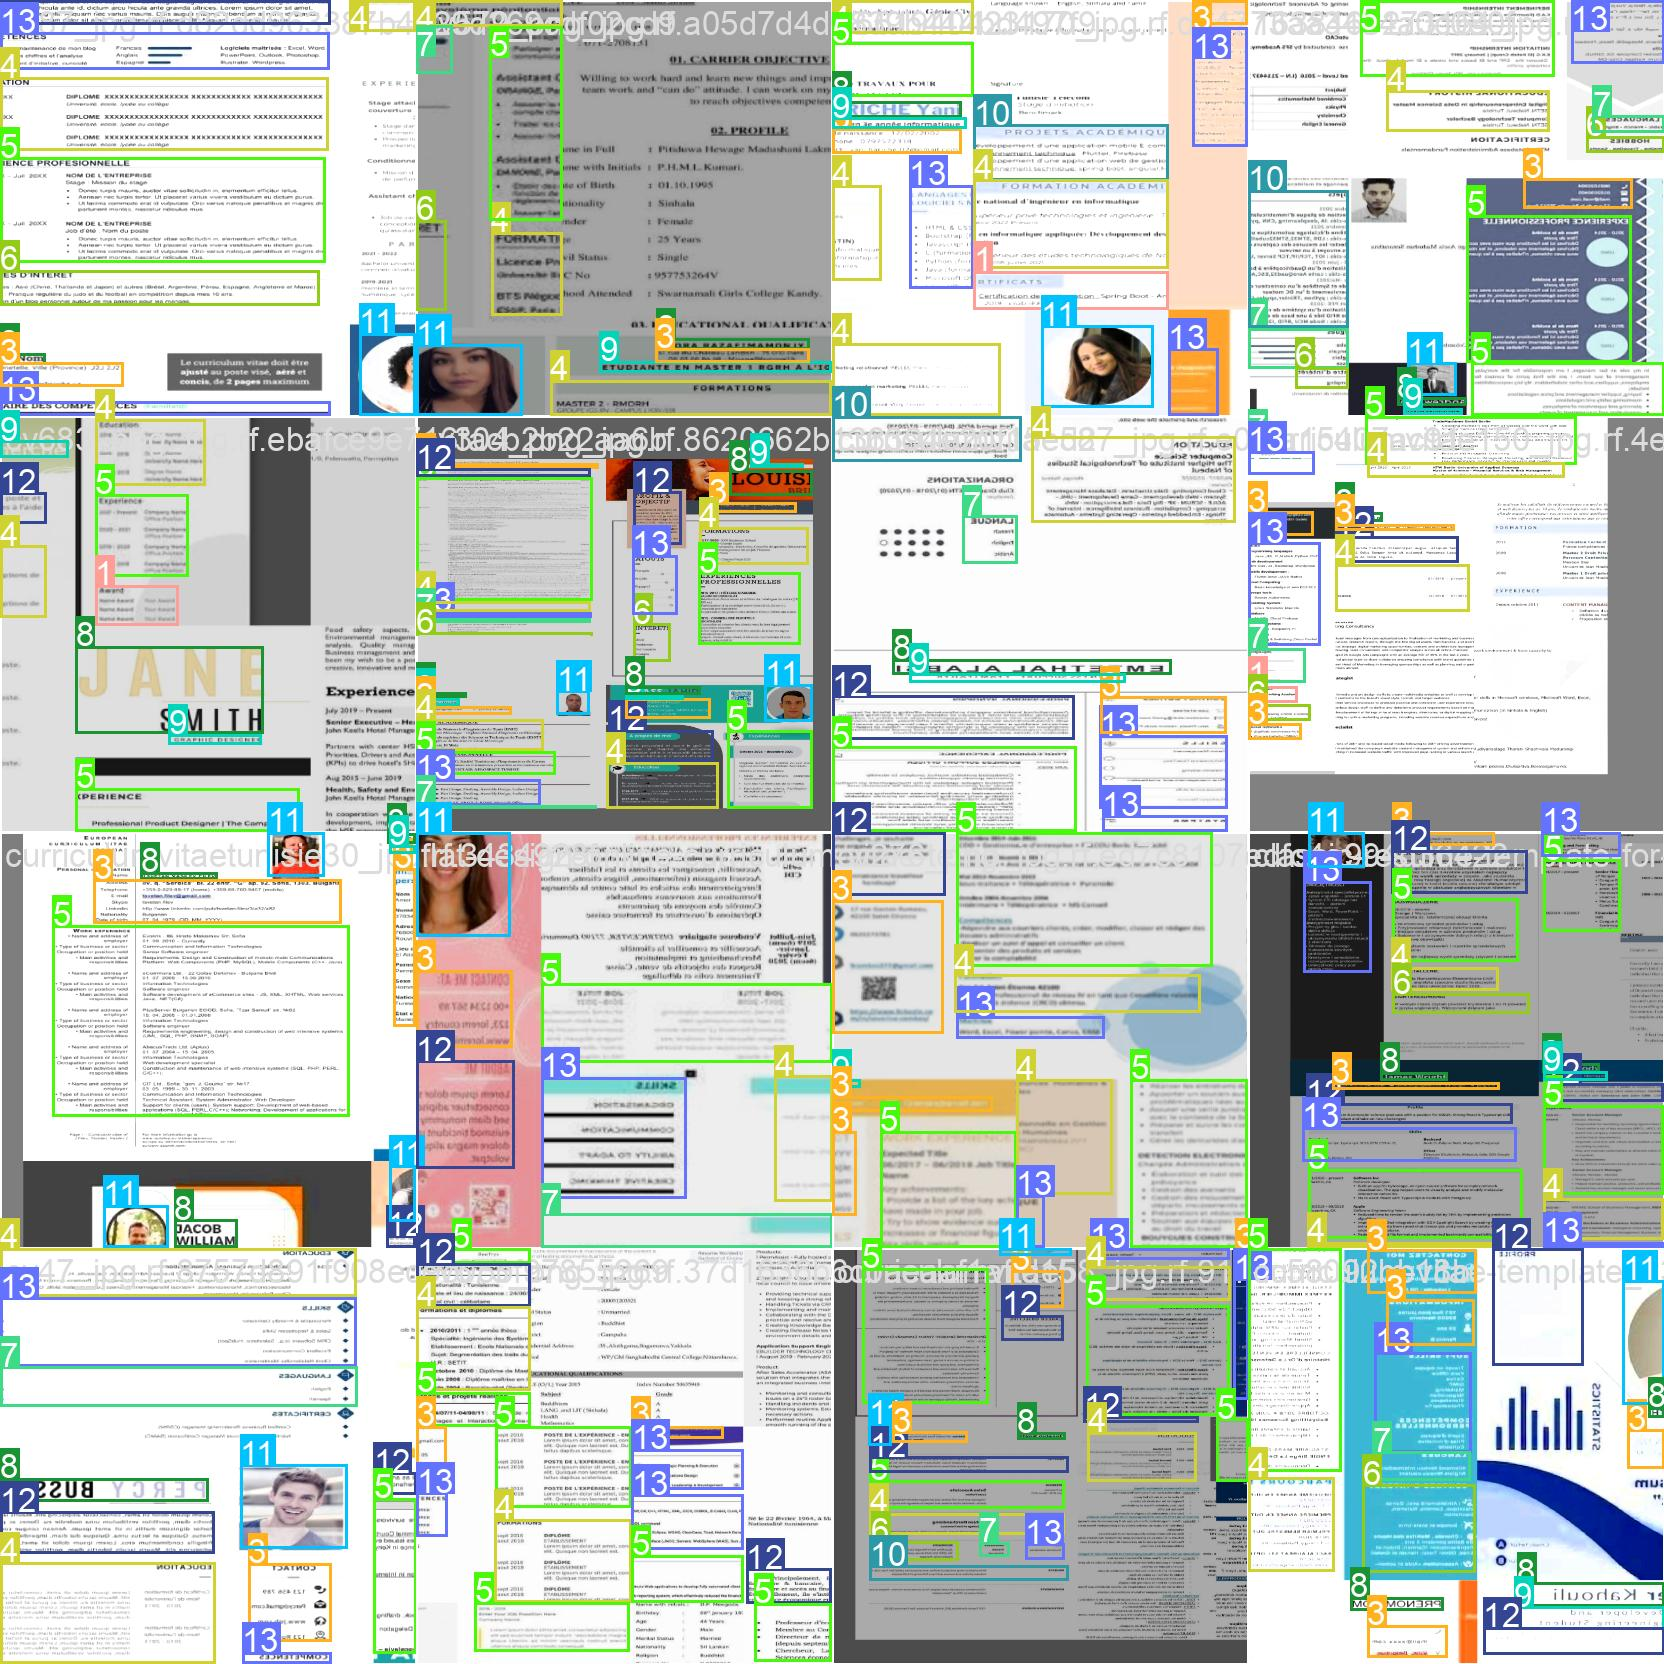

In [ ]:
!pip install roboflow

In [ ]:
!apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 18 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.2 [186 kB]
Fetched 186 kB in 1s (147 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 120942 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.2_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.2) ...
Setting up poppler-utils (22.02.0-2ubuntu0.2) ...
Processing triggers for man-db (2.10.2-1) ...


loading Roboflow workspace...
loading Roboflow project...
{'predictions': [{'x': 232, 'y': 1151, 'width': 391, 'height': 208, 'confidence': 0.946067214012146, 'class': 'Education', 'class_id': 4, 'image_path': '/content/vikas1.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 616, 'y': 467, 'width': 1178, 'height': 200, 'confidence': 0.9341152906417847, 'class': 'resume', 'class_id': 12, 'image_path': '/content/vikas1.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 886, 'y': 822, 'width': 589, 'height': 356, 'confidence': 0.9259357452392578, 'class': 'skills', 'class_id': 13, 'image_path': '/content/vikas1.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 322, 'y': 132, 'width': 471, 'height': 63, 'confidence': 0.8759822845458984, 'class': 'Name', 'class_id': 8, 'image_path': '/content/vikas1.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 119, 'y': 740, 'width': 180, 'height': 170, 'confidence': 0.8659465312957764, 'class': 'Contact', 'class_id': 3, 'image_

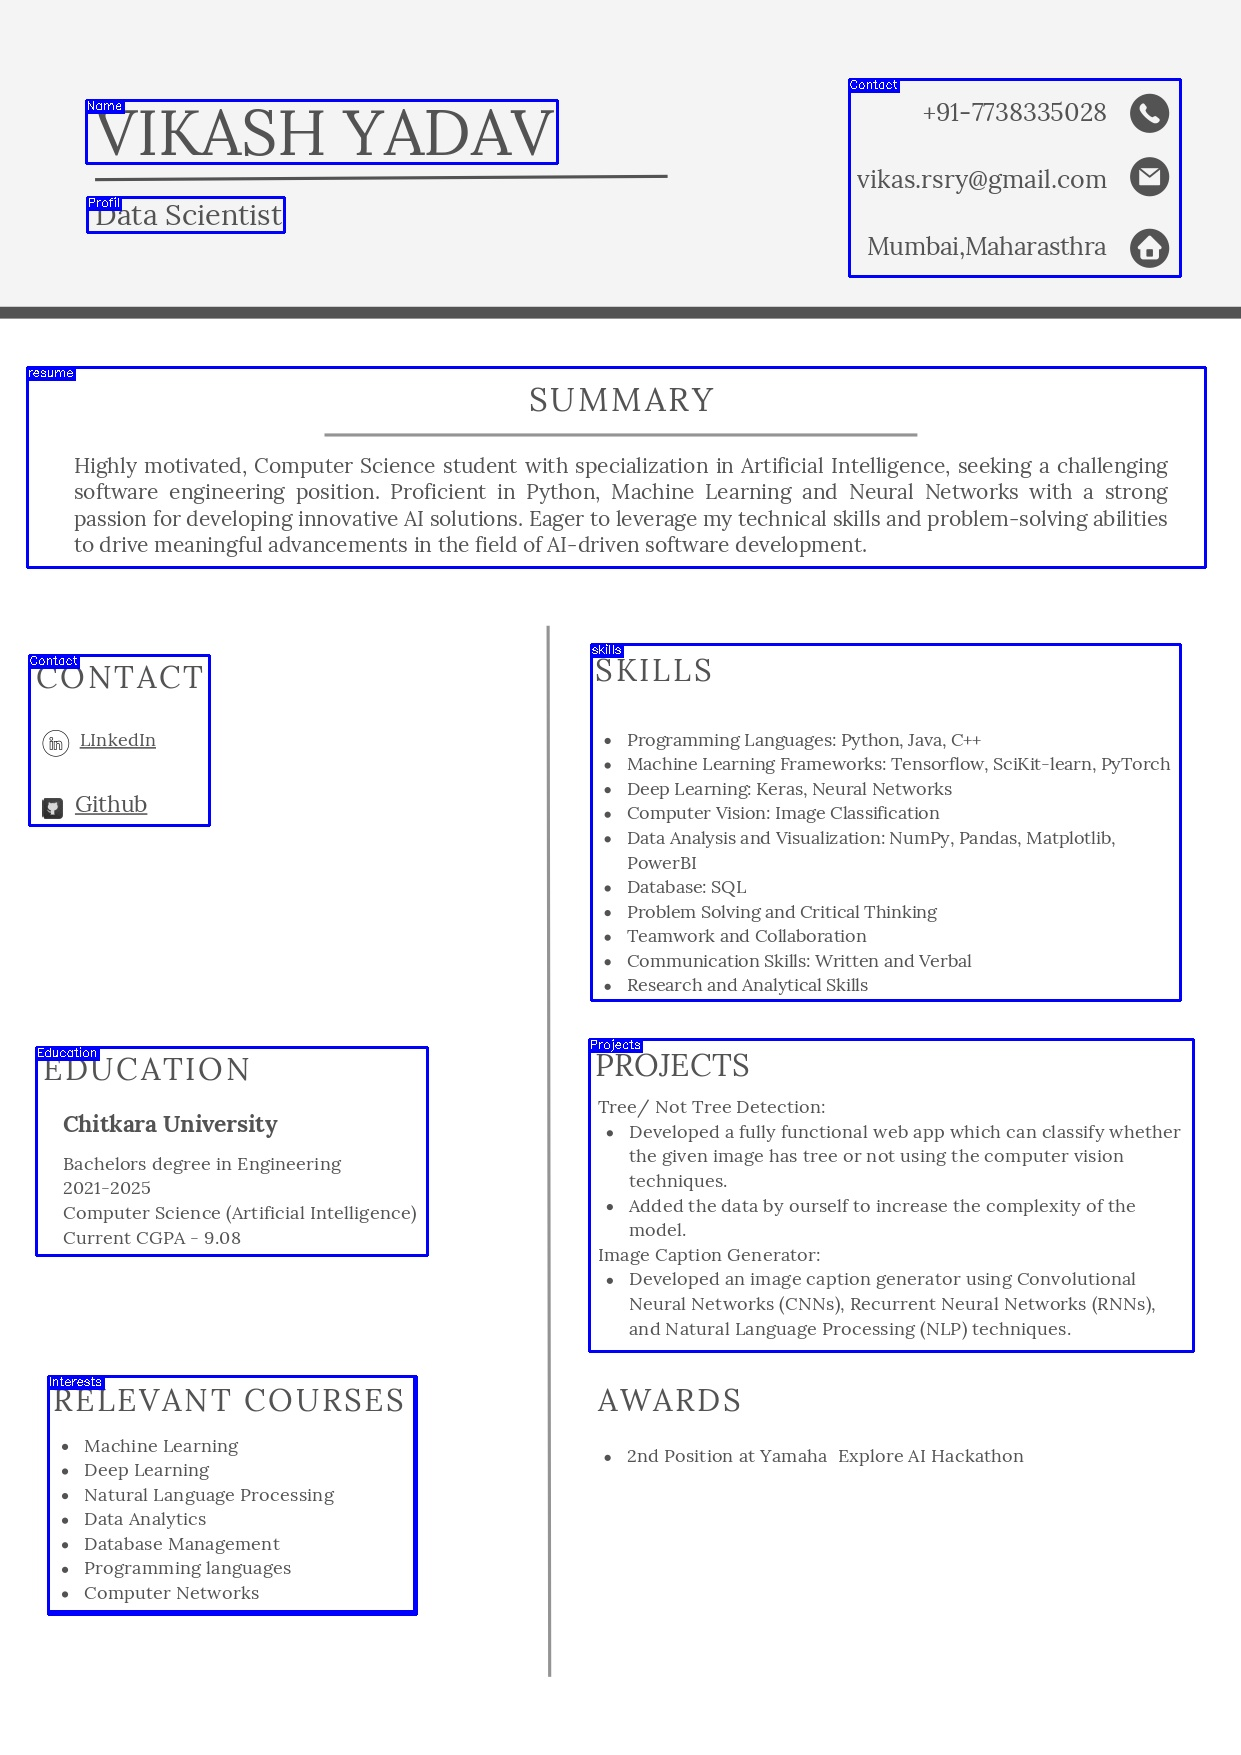

In [ ]:
from roboflow import Roboflow
from IPython.display import display, Image as IPImage

# Initialize Roboflow
rf = Roboflow(api_key="QsK90UUHzIAOlSrUEEy2")
project = rf.workspace().project("resume-parser-bchlq")
model = project.version(1).model

# Path to your local image
image_path = "/content/vikas1.jpg"

# Infer on the local image
predictions = model.predict(image_path, confidence=40, overlap=30).json()

# Print the predictions dictionary
print(predictions)

# Save the image with predictions
output_image_path = "/content/prediction.jpg"
model.predict(image_path, confidence=40, overlap=30).save(output_image_path)

# Display the image with predictions
display(IPImage(output_image_path))


In [ ]:
# Here's a brief explanation of the parameters:
# confidence: It is a threshold that determines the minimum confidence score a prediction must have to be considered. Predictions with scores below this threshold are usually discarded.
# overlap: This parameter sets the threshold for the amount of overlap required between two bounding boxes to trigger non-maximum suppression. If the overlap between two bounding boxes is greater than or equal to this threshold, the one with the lower confidence score is removed.
# In your case, with overlap=30, it means that if the overlap between two bounding boxes is 30% or more, non-maximum suppression will be applied to keep only the one with the higher confidence score.This parameter is often used to control the trade-off between sensitivity and precision in object detection tasks. Adjusting the overlap threshold can impact how tightly or loosely bounding boxes are clustered around objects in the image.

loading Roboflow workspace...
loading Roboflow project...


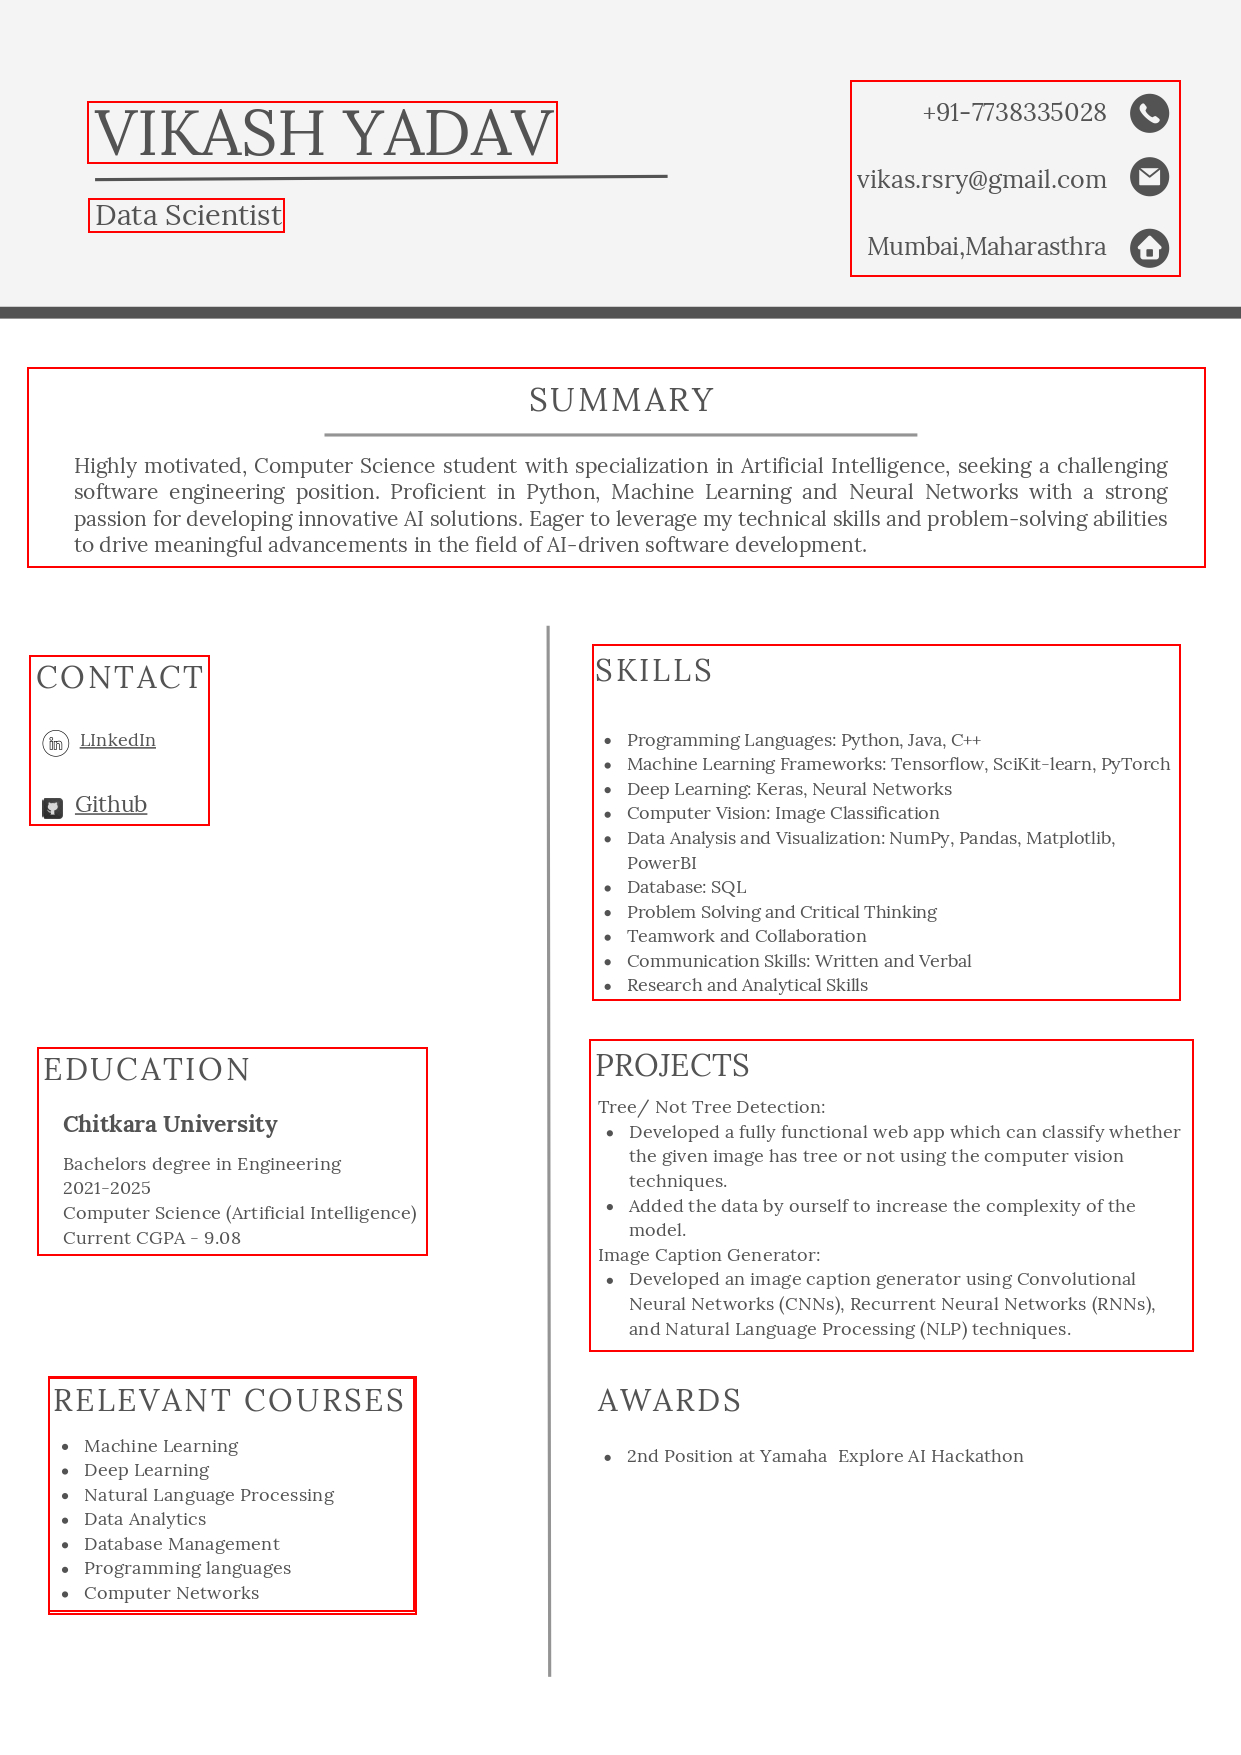

Segment 1


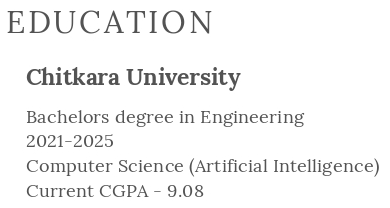

Segment 2


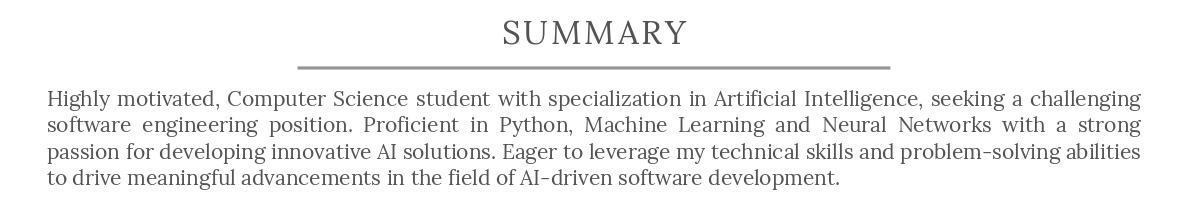

Segment 3


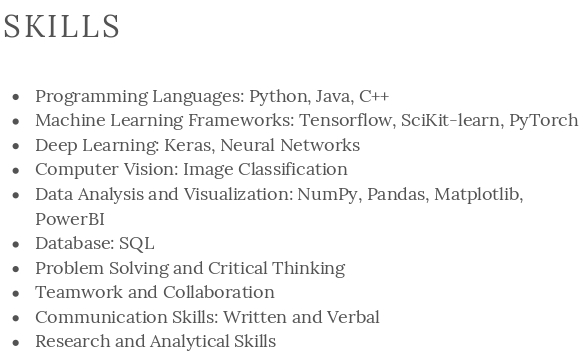

Segment 4


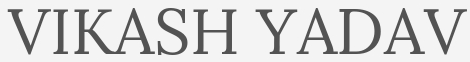

Segment 5


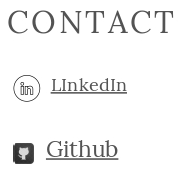

Segment 6


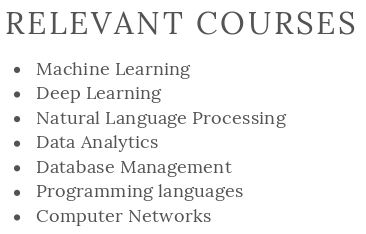

Segment 7


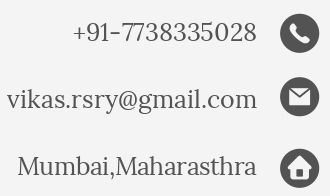

Segment 8


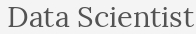

Segment 9


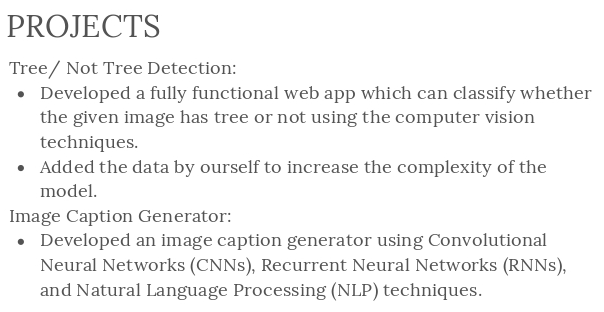

Segment 10


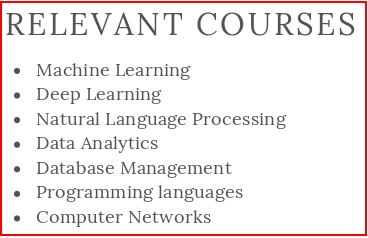

[<PIL.Image.Image image mode=RGB size=390x208>,
 <PIL.Image.Image image mode=RGB size=1178x200>,
 <PIL.Image.Image image mode=RGB size=588x356>,
 <PIL.Image.Image image mode=RGB size=470x62>,
 <PIL.Image.Image image mode=RGB size=180x170>,
 <PIL.Image.Image image mode=RGB size=366x234>,
 <PIL.Image.Image image mode=RGB size=330x196>,
 <PIL.Image.Image image mode=RGB size=196x34>,
 <PIL.Image.Image image mode=RGB size=604x312>,
 <PIL.Image.Image image mode=RGB size=368x238>]

In [ ]:
from PIL import Image, ImageDraw
from roboflow import Roboflow
from IPython.display import display

def extract_and_display_segments(image_path, model, shift_factor=20, vertical_shift_factor=20, increase_factor=20):
    # Load the image
    image = Image.open(image_path)

    # Create an ImageDraw object
    draw = ImageDraw.Draw(image)

    # Get predictions using the model
    predictions = model.predict(image_path, confidence=40, overlap=30).json()

    # Create a list to store cropped segments
    cropped_segments = []

    # Iterate through predictions and crop segments
    for prediction in predictions['predictions']:
        x, y, w, h = map(int, (prediction['x'], prediction['y'], prediction['width'], prediction['height']))

        # Ensure coordinates are within the image bounds
        x1 = max(0, x - w // 2)
        y1 = max(0, y - h // 2)
        x2 = min(image.width, x + w // 2)
        y2 = min(image.height, y + h // 2)

        # Crop the segment from the original image
        segment = image.crop((x1, y1, x2, y2))

        # Append the cropped segment to the list
        cropped_segments.append(segment)

        # Draw the adjusted bounding box on the image
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)

    # Display the image with adjusted bounding boxes
    display(image)

    # Display the cropped segments
    for i, segment in enumerate(cropped_segments):
        print(f"Segment {i + 1}")
        display(segment)

    return cropped_segments

# Initialize Roboflow
rf = Roboflow(api_key="QsK90UUHzIAOlSrUEEy2")
project = rf.workspace().project("resume-parser-bchlq")
model = project.version(1).model

# Path to your local image
image_path = "/content/vikas1.jpg"

# Call the function to extract and display segments
extract_and_display_segments(image_path, model)


In [ ]:
!pip install pytesseract

In [ ]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 18 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 3s (1,768 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

loading Roboflow workspace...
loading Roboflow project...


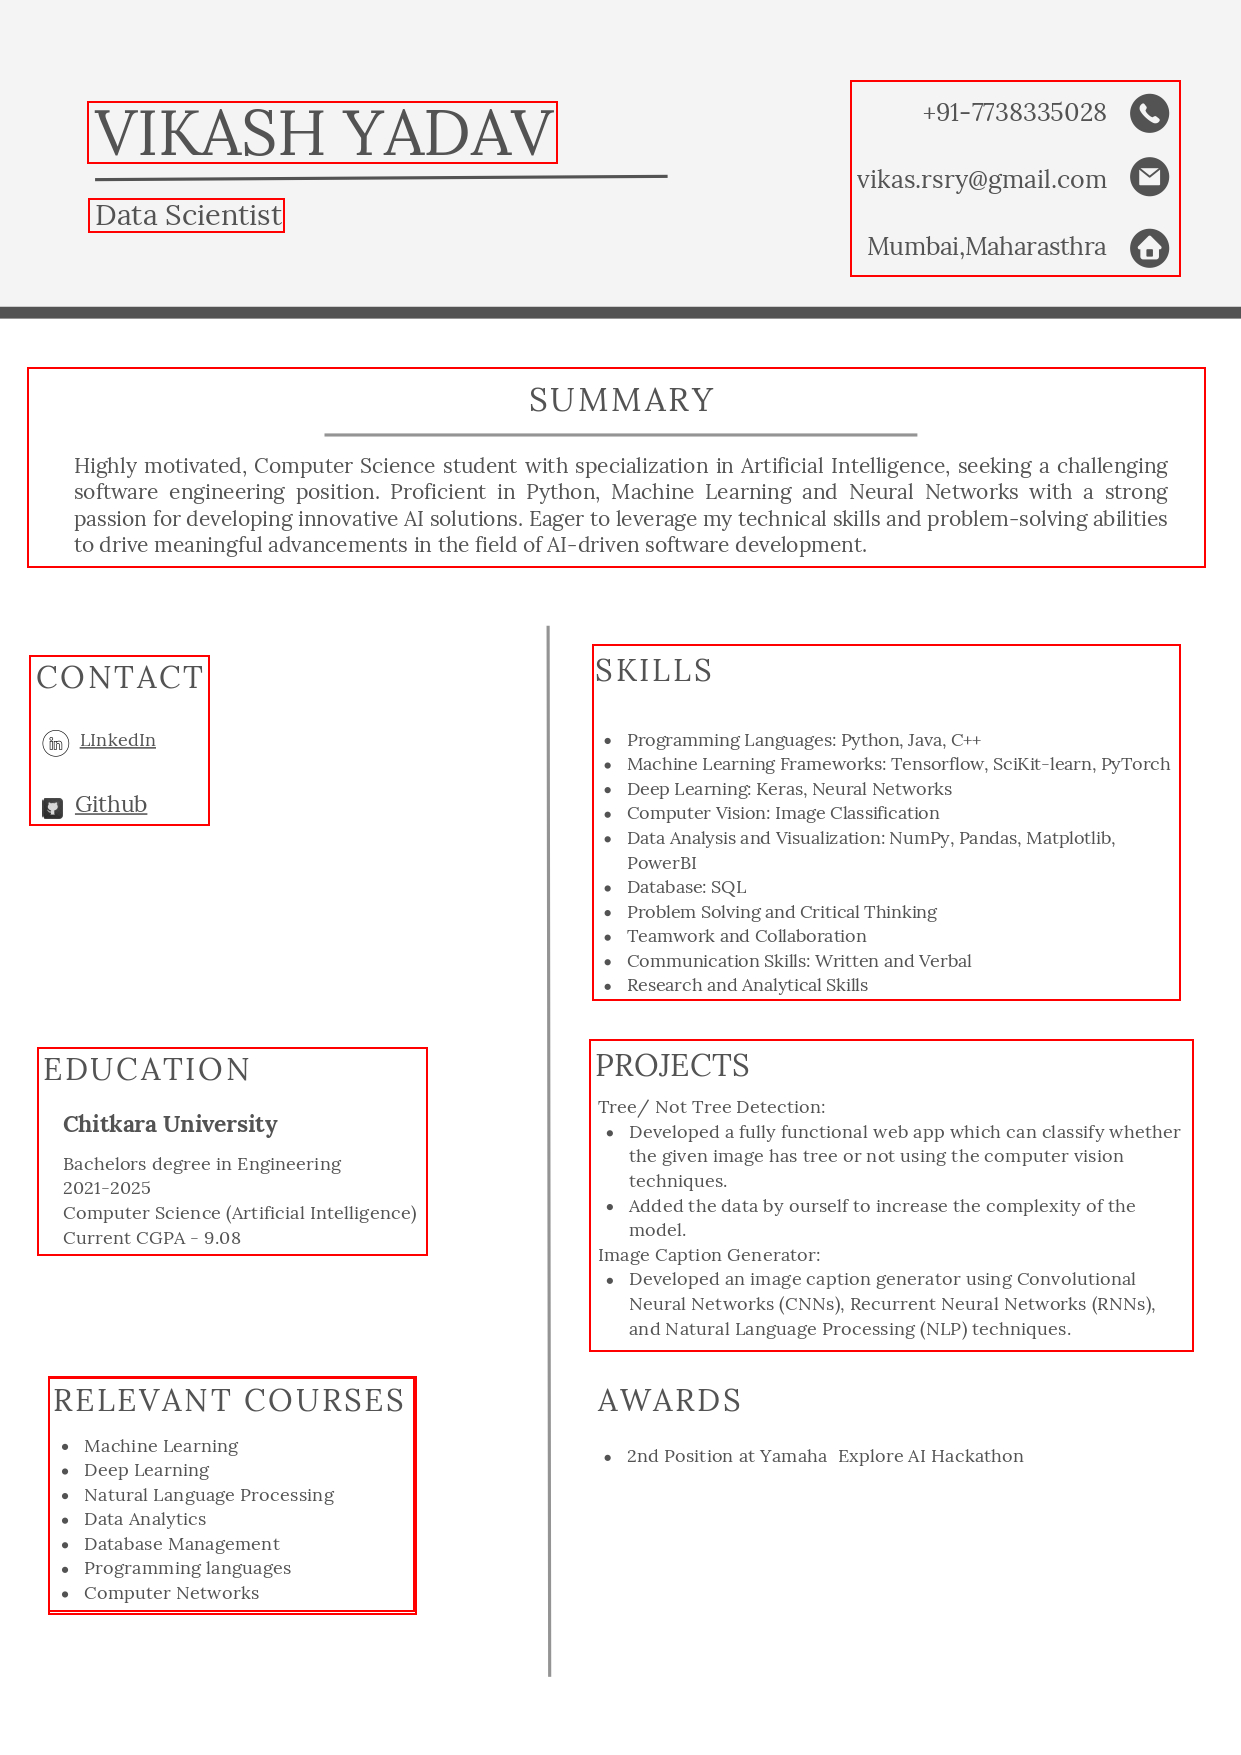

Segment 1 - OCR Text: EDUCATION

Chitkara University

Bachelors degree in Engineering
2021-2025

Computer Science (Artificial Intelligence)
Current CGPA - 9.08



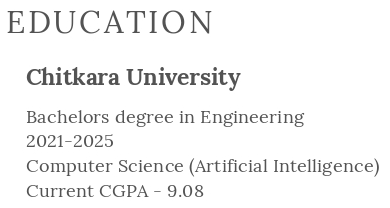

Segment 2 - OCR Text: SUMMARY

 

Highly motivated, Computer Science student with specialization in Artificial Intelligence, seeking a challenging
software engineering position. Proficient in Python, Machine Learning and Neural Networks with a strong
passion for developing innovative AI solutions. Eager to leverage my technical skills and problem-solving abilities
to drive meaningful advancements in the field of Al-driven software development.



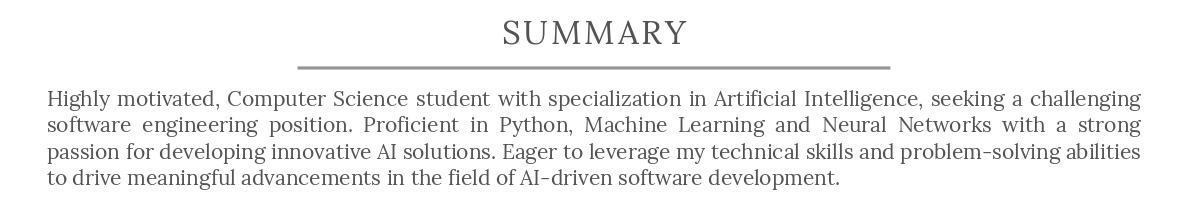

Segment 3 - OCR Text: SKILLS

+ Programming Languages: Python, Java, C++

* Machine Learning Frameworks: Tensorflow, SciKit-learn, PyTorch

+ Deep Learning Keras, Neural Networks

* Computer Vision: Image Classification

* Data Analysis and Visualization: NumPy, Pandas, Matplotlib,
PowerBI

* Database: SQL

+ Problem Solving and Critical Thinking

* Teamwork and Collaboration

* Communication Skills: Written and Verbal

+ Research and Analytical Skills



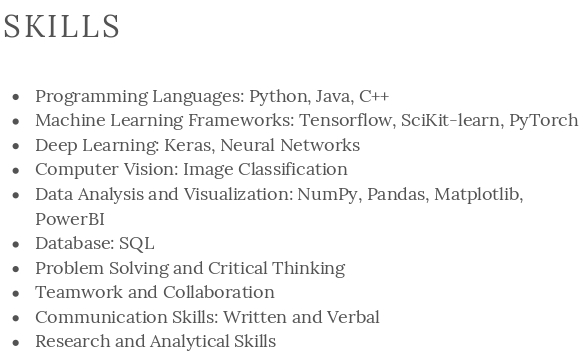

Segment 4 - OCR Text: VIKASH YADAV



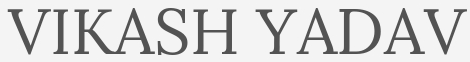

Segment 5 - OCR Text: CONTACT
LinkedIn

@ Github

 



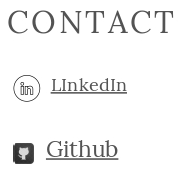

Segment 6 - OCR Text: RELEVANT COURSES

* Machine Learning

« Deep Learning

« Natural Language Processing
* Data Analytics

« Database Management

« Programming languages

« Computer Networks



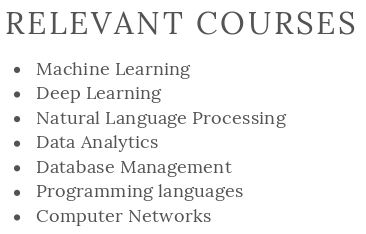

Segment 7 - OCR Text: +91-7738335028 @
vikas.rsry@gmail.com ©

Mumbai,Maharasthra oO



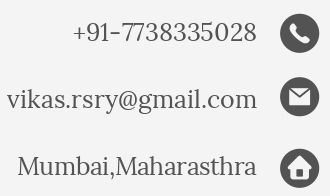

Segment 8 - OCR Text: Data Scientist



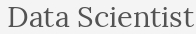

Segment 9 - OCR Text: PROJECTS

Tree/ Not Tree Detection:
* Developed a fully functional web app which can classify whether
the given image has tree or not using the computer vision
techniques.
* Added the data by ourself to increase the complexity of the
model.
Image Caption Generator:
* Developed an image caption generator using Convolutional
Neural Networks (CNNs), Recurrent Neural Networks (RNNs),
and Natural Language Processing (NLP) techniques.



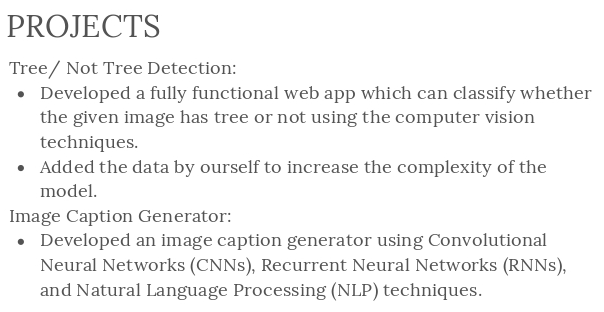

Segment 10 - OCR Text:  

 

RELEVANT COURSES

* Machine Learning

« Deep Learning

« Natural Language Processing
* Data Analytics

« Database Management

« Programming languages

« Computer Networks

 

 



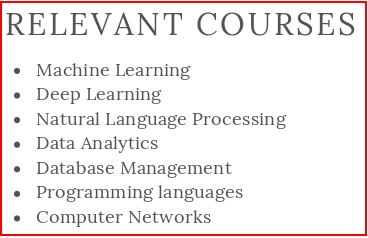

[(<PIL.Image.Image image mode=RGB size=390x208>,
  'EDUCATION\n\nChitkara University\n\nBachelors degree in Engineering\n2021-2025\n\nComputer Science (Artificial Intelligence)\nCurrent CGPA - 9.08\n\x0c'),
 (<PIL.Image.Image image mode=RGB size=1178x200>,
  'SUMMARY\n\n \n\nHighly motivated, Computer Science student with specialization in Artificial Intelligence, seeking a challenging\nsoftware engineering position. Proficient in Python, Machine Learning and Neural Networks with a strong\npassion for developing innovative AI solutions. Eager to leverage my technical skills and problem-solving abilities\nto drive meaningful advancements in the field of Al-driven software development.\n\x0c'),
 (<PIL.Image.Image image mode=RGB size=588x356>,
  'SKILLS\n\n+ Programming Languages: Python, Java, C++\n\n* Machine Learning Frameworks: Tensorflow, SciKit-learn, PyTorch\n\n+ Deep Learning Keras, Neural Networks\n\n* Computer Vision: Image Classification\n\n* Data Analysis and Visualization: Nu

In [ ]:
from PIL import Image, ImageDraw
from roboflow import Roboflow
from IPython.display import display
import pytesseract

def apply_ocr(image):
    # Convert the image to grayscale
    gray_image = image.convert('L')

    # Use pytesseract to perform OCR
    text = pytesseract.image_to_string(gray_image)

    return text

def extract_and_display_segments_with_ocr(image_path, model, shift_factor=20, vertical_shift_factor=20, increase_factor=20):
    # Load the image
    image = Image.open(image_path)

    # Create an ImageDraw object
    draw = ImageDraw.Draw(image)

    # Get predictions using the model
    predictions = model.predict(image_path, confidence=40, overlap=30).json()

    # Create a list to store cropped segments and their text
    segments_with_text = []

    # Iterate through predictions and crop segments
    for prediction in predictions['predictions']:
        x, y, w, h = map(int, (prediction['x'], prediction['y'], prediction['width'], prediction['height']))

        # Ensure coordinates are within the image bounds
        x1 = max(0, x - w // 2)
        y1 = max(0, y - h // 2)
        x2 = min(image.width, x + w // 2)
        y2 = min(image.height, y + h // 2)

        # Crop the segment from the original image
        segment = image.crop((x1, y1, x2, y2))

        # Apply OCR to the segment
        text = apply_ocr(segment)

        # Append the cropped segment and text to the list
        segments_with_text.append((segment, text))

        # Draw the adjusted bounding box on the image
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)

    # Display the image with adjusted bounding boxes
    display(image)

    # Display the cropped segments and their text
    for i, (segment, text) in enumerate(segments_with_text):
        print(f"Segment {i + 1} - OCR Text: {text}")
        display(segment)

    return segments_with_text

# Initialize Roboflow
rf = Roboflow(api_key="QsK90UUHzIAOlSrUEEy2")
project = rf.workspace().project("resume-parser-bchlq")
model = project.version(1).model

# Path to your local image
image_path = "/content/vikas1.jpg"

# Call the function to extract and display segments with OCR
extract_and_display_segments_with_ocr(image_path, model)


loading Roboflow workspace...
loading Roboflow project...


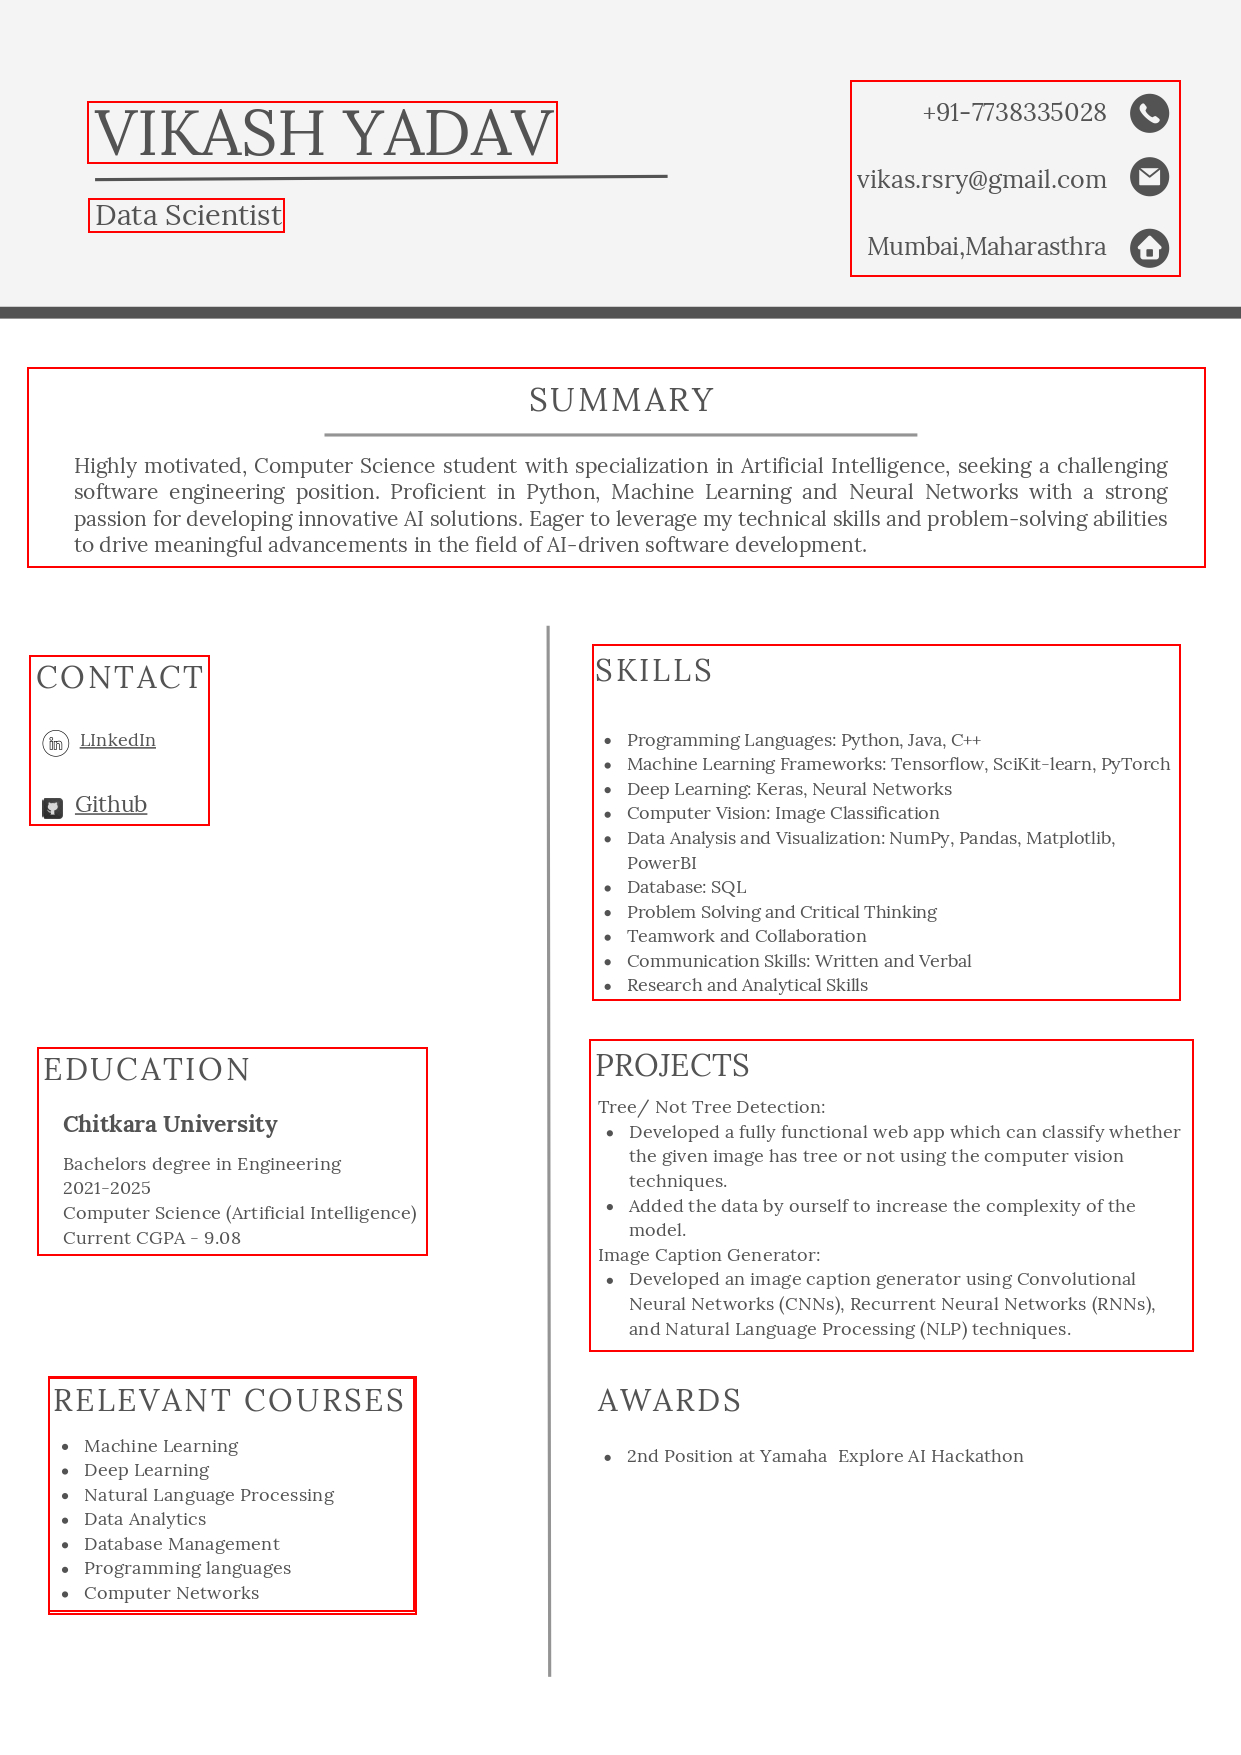

{'Education': 'EDUCATION\n\nChitkara University\n\nBachelors degree in Engineering\n2021-2025\n\nComputer Science (Artificial Intelligence)\nCurrent CGPA - 9.08\n\x0c',
 'resume': 'SUMMARY\n\n \n\nHighly motivated, Computer Science student with specialization in Artificial Intelligence, seeking a challenging\nsoftware engineering position. Proficient in Python, Machine Learning and Neural Networks with a strong\npassion for developing innovative AI solutions. Eager to leverage my technical skills and problem-solving abilities\nto drive meaningful advancements in the field of Al-driven software development.\n\x0c',
 'skills': 'RELEVANT COURSES\n\n* Machine Learning\n\n« Deep Learning\n\n« Natural Language Processing\n* Data Analytics\n\n« Database Management\n\n« Programming languages\n\n« Computer Networks\n\x0c',
 'Name': 'VIKASH YADAV\n\x0c',
 'Contact': '+91-7738335028 @\nvikas.rsry@gmail.com ©\n\nMumbai,Maharasthra oO\n\x0c',
 'Profil': 'Data Scientist\n\x0c',
 'Projects': 'PROJECT

Education - OCR Text: EDUCATION

Chitkara University

Bachelors degree in Engineering
2021-2025

Computer Science (Artificial Intelligence)
Current CGPA - 9.08

resume - OCR Text: SUMMARY

 

Highly motivated, Computer Science student with specialization in Artificial Intelligence, seeking a challenging
software engineering position. Proficient in Python, Machine Learning and Neural Networks with a strong
passion for developing innovative AI solutions. Eager to leverage my technical skills and problem-solving abilities
to drive meaningful advancements in the field of Al-driven software development.

skills - OCR Text: RELEVANT COURSES

* Machine Learning

« Deep Learning

« Natural Language Processing
* Data Analytics

« Database Management

« Programming languages

« Computer Networks

Name - OCR Text: VIKASH YADAV

Contact - OCR Text: +91-7738335028 @
vikas.rsry@gmail.com ©

Mumbai,Maharasthra oO

Profil - OCR Text: Data Scientist

Projects - OCR Text: PROJECTS

Tree/ Not Tree 

In [ ]:
from PIL import Image, ImageDraw
from roboflow import Roboflow
from IPython.display import display
import pytesseract

def apply_ocr(image):
    # Convert the image to grayscale
    gray_image = image.convert('L')

    # Use pytesseract to perform OCR
    text = pytesseract.image_to_string(gray_image)

    return text

def extract_and_display_segments_with_ocr(image_path, model, shift_factor=20, vertical_shift_factor=20, increase_factor=20):
    # Load the image
    image = Image.open(image_path)

    # Create an ImageDraw object
    draw = ImageDraw.Draw(image)

    # Get predictions using the model
    predictions = model.predict(image_path, confidence=40, overlap=30).json()

    # Create a dictionary to store OCR results with labels
    ocr_results = {}

    # Iterate through predictions and crop segments
    for prediction in predictions['predictions']:
        x, y, w, h = map(int, (prediction['x'], prediction['y'], prediction['width'], prediction['height']))

        # Ensure coordinates are within the image bounds
        x1 = max(0, x - w // 2)
        y1 = max(0, y - h // 2)
        x2 = min(image.width, x + w // 2)
        y2 = min(image.height, y + h // 2)

        # Crop the segment from the original image
        segment = image.crop((x1, y1, x2, y2))

        # Apply OCR to the segment
        text = apply_ocr(segment)

        # Use the 'class' provided in the predictions as the dictionary key
        class_label = prediction.get('class', 'Unknown')
        ocr_results[class_label] = text

        # Draw the adjusted bounding box on the image
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)

    # Display the image with adjusted bounding boxes
    display(image)

    # Display the cropped segments and their text
    for label, text in ocr_results.items():
        print(f"{label} - OCR Text: {text}")

    return ocr_results

# Initialize Roboflow
rf = Roboflow(api_key="QsK90UUHzIAOlSrUEEy2")
project = rf.workspace().project("resume-parser-bchlq")
model = project.version(1).model

# Path to your local image
image_path = "/content/vikas1.jpg"

# Call the function to extract and display segments with OCR
extract_and_display_segments_with_ocr(image_path, model)


In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import re

def preprocess_text(text, class_name):
    # Load spaCy model
    nlp = spacy.load("en_core_web_sm")

    # Process the text using spaCy
    doc = nlp(text)

    # Remove stop words and non-alphabetic characters
    processed_tokens = []
    for i, token in enumerate(doc):
        # Keep the case of the first word in each sentence
        if i == 0 or doc[i - 1].is_punct:
            processed_tokens.append(token.text)
        else:
            processed_tokens.append(token.text.lower() if token.text.lower() not in STOP_WORDS else '')

    # Join the processed tokens into a string
    processed_text = ' '.join(processed_tokens)

    # Remove the class name if it appears at the beginning of the text
    processed_text = re.sub(fr'^{class_name.lower()} ', '', processed_text.lower())

    return processed_text

def clean_and_structure_data(ocr_results):
    cleaned_data = {}

    for label, text in ocr_results.items():
        # Preprocess the text
        cleaned_text = preprocess_text(text, label)

        # Store the cleaned text in the dictionary
        cleaned_data[label] = cleaned_text

    return cleaned_data

# Use the OCR results from the previous step
ocr_results = {
    'Education': 'EDUCATION\n\nChitkara University\n\nBachelors degree in Engineering\n2021-2025\n\nComputer Science (Artificial Intelligence)\nCurrent CGPA - 9.08\n\x0c',
    'resume': 'SUMMARY\n\n \n\nHighly motivated, Computer Science student with specialization in Artificial Intelligence, seeking a challenging\nsoftware engineering position. Proficient in Python, Machine Learning and Neural Networks with a strong\npassion for developing innovative AI solutions. Eager to leverage my technical skills and problem-solving abilities\nto drive meaningful advancements in the field of Al-driven software development.\n\x0c',
    'skills': 'RELEVANT COURSES\n\n* Machine Learning\n\n« Deep Learning\n\n« Natural Language Processing\n* Data Analytics\n\n« Database Management\n\n« Programming languages\n\n« Computer Networks\n\x0c',
    'Name': 'VIKASH YADAV\n\x0c',
    'Contact': '+91-7738335028 @\nvikas.rsry@gmail.com ©\n\nMumbai,Maharasthra oO\n\x0c',
    'Profil': 'Data Scientist\n\x0c',
    'Projects': 'PROJECTS\n\nTree/ Not Tree Detection:\n* Developed a fully functional web app which can classify whether\nthe given image has tree or not using the computer vision\ntechniques.\n* Added the data by ourself to increase the complexity of the\nmodel.\nImage Caption Generator:\n* Developed an image caption generator using Convolutional\nNeural Networks (CNNs), Recurrent Neural Networks (RNNs),\nand Natural Language Processing (NLP) techniques.\n\x0c',
    'Interests': ' \n\n \n\nRELEVANT COURSES\n\n* Machine Learning\n\n« Deep Learning\n\n« Natural Language Processing\n* Data Analytics\n\n« Database Management\n\n« Programming languages\n\n« Computer Networks\n\n \n\n \n\x0c'
}

# Clean and structure the data
cleaned_data = clean_and_structure_data(ocr_results)

# Display the cleaned and structured data
for label, text in cleaned_data.items():
    print(f"{label}:\n{text}\n")


Education:


 chitkara university 

 bachelors degree  engineering 
 2021 - 2025 

 computer science ( artificial intelligence ) 
 current cgpa - 9.08 


resume:
summary 

 

 highly motivated , computer science student  specialization  artificial intelligence , seeking  challenging 
 software engineering position . proficient  python , machine learning  neural networks   strong 
 passion  developing innovative ai solutions . eager  leverage  technical skills  problem - solving abilities 
  drive meaningful advancements   field  al - driven software development . 


skills:
relevant courses 

 * machine learning 

 « deep learning 

 « natural language processing 
 * data analytics 

 « database management 

 « programming languages 

 « computer networks 


Name:
vikash yadav 


Contact:
+91 - 7738335028 @ 
 vikas.rsry@gmail.com © 

 mumbai , maharasthra oo 


Profil:
data scientist 


Projects:


 tree/  tree detection : 
 * developed  fully functional web app   classify  
  gi

In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import re
import pandas as pd

def preprocess_text(text, class_name):
    # Load spaCy model
    nlp = spacy.load("en_core_web_sm")

    # Process the text using spaCy
    doc = nlp(text)

    # Remove stop words and non-alphabetic characters
    processed_tokens = []
    for i, token in enumerate(doc):
        # Keep the case of the first word in each sentence
        if i == 0 or doc[i - 1].is_punct:
            processed_tokens.append(token.text)
        else:
            processed_tokens.append(token.text.lower() if token.text.lower() not in STOP_WORDS else '')

    # Join the processed tokens into a string
    processed_text = ' '.join(processed_tokens)

    # Remove the class name if it appears at the beginning of the text
    processed_text = re.sub(fr'^{class_name.lower()} ', '', processed_text.lower())

    return processed_text

def clean_and_structure_data(ocr_results):
    cleaned_data = {}

    for label, text in ocr_results.items():
        # Preprocess the text
        cleaned_text = preprocess_text(text, label)

        # Store the cleaned text in the dictionary
        cleaned_data[label] = cleaned_text

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(list(cleaned_data.items()), columns=['Label', 'Text'])
    return df

# Use the OCR results from the previous step
ocr_results = {
    'Education': 'EDUCATION\n\nChitkara University\n\nBachelors degree in Engineering\n2021-2025\n\nComputer Science (Artificial Intelligence)\nCurrent CGPA - 9.08\n\x0c',
    'resume': 'SUMMARY\n\n \n\nHighly motivated, Computer Science student with specialization in Artificial Intelligence, seeking a challenging\nsoftware engineering position. Proficient in Python, Machine Learning and Neural Networks with a strong\npassion for developing innovative AI solutions. Eager to leverage my technical skills and problem-solving abilities\nto drive meaningful advancements in the field of Al-driven software development.\n\x0c',
    'skills': 'RELEVANT COURSES\n\n* Machine Learning\n\n« Deep Learning\n\n« Natural Language Processing\n* Data Analytics\n\n« Database Management\n\n« Programming languages\n\n« Computer Networks\n\x0c',
    'Name': 'VIKASH YADAV\n\x0c',
    'Contact': '+91-7738335028 @\nvikas.rsry@gmail.com ©\n\nMumbai,Maharasthra oO\n\x0c',
    'Profil': 'Data Scientist\n\x0c',
    'Projects': 'PROJECTS\n\nTree/ Not Tree Detection:\n* Developed a fully functional web app which can classify whether\nthe given image has tree or not using the computer vision\ntechniques.\n* Added the data by ourself to increase the complexity of the\nmodel.\nImage Caption Generator:\n* Developed an image caption generator using Convolutional\nNeural Networks (CNNs), Recurrent Neural Networks (RNNs),\nand Natural Language Processing (NLP) techniques.\n\x0c',
    'Interests': ' \n\n \n\nRELEVANT COURSES\n\n* Machine Learning\n\n« Deep Learning\n\n« Natural Language Processing\n* Data Analytics\n\n« Database Management\n\n« Programming languages\n\n« Computer Networks\n\n \n\n \n\x0c'
}

# Clean and structure the data
df = clean_and_structure_data(ocr_results)

# Display the DataFrame
print(df)


       Label                                               Text
0  Education  \n\n chitkara university \n\n bachelors degree...
1     resume  summary \n\n \n\n highly motivated , computer ...
2     skills  relevant courses \n\n * machine learning \n\n ...
3       Name                                   vikash yadav \n
4    Contact  +91 - 7738335028 @ \n vikas.rsry@gmail.com © \...
5     Profil                                 data scientist \n
6   Projects  \n\n tree/  tree detection : \n * developed  f...
7  Interests   \n\n \n\n relevant courses \n\n * machine lea...


In [ ]:
df

Label                                               Text
0  Education  \n\n chitkara university \n\n bachelors degree...
1     resume  summary \n\n \n\n highly motivated , computer ...
2     skills  relevant courses \n\n * machine learning \n\n ...
3       Name                                   vikash yadav \n

4    Contact  +91 - 7738335028 @ \n vikas.rsry@gmail.com © \...
5     Profil                                 data scientist \n

6   Projects  \n\n tree/  tree detection : \n * developed  f...
7  Interests   \n\n \n\n relevant courses \n\n * machine lea...

In [ ]:
df['Text'] = df['Text'].str.replace('\n', '')
df

Label                                               Text
0  Education   chitkara university  bachelors degree  engine...
1     resume  summary   highly motivated , computer science ...
2     skills  relevant courses  * machine learning  « deep l...
3       Name                                     vikash yadav 

4    Contact  +91 - 7738335028 @  vikas.rsry@gmail.com ©  mu...
5     Profil                                   data scientist 

6   Projects   tree/  tree detection :  * developed  fully f...
7  Interests     relevant courses  * machine learning  « dee...

In [ ]:
import pandas as pd
import re

def preprocess_text(row):
    if row['Label'] != 'Contact' and row['Label'] != 'Education':
        row['Text'] = re.sub(r'[^a-zA-Z0-9, ]', '', row['Text'])
    return row

# Assuming df is your DataFrame
df = df.apply(preprocess_text, axis=1)

df


Label                                               Text
0  Education   chitkara university  bachelors degree  engine...
1     resume  summary   highly motivated , computer science ...
2     skills  relevant courses   machine learning   deep lea...
3       Name                                      vikash yadav 
4    Contact  +91 - 7738335028 @  vikas.rsry@gmail.com ©  mu...
5     Profil                                    data scientist 
6   Projects   tree  tree detection    developed  fully func...
7  Interests     relevant courses   machine learning   deep ...

In [ ]:
from PIL import Image, ImageDraw
from roboflow import Roboflow
import pytesseract
import re

def apply_ocr(image):
    # Convert the image to grayscale
    gray_image = image.convert('L')

    # Use pytesseract to perform OCR
    text = pytesseract.image_to_string(gray_image)

    return text

def clean_ocr_text(ocr_text, class_name):
    # Remove newline characters
    cleaned_text = ocr_text.replace('\n', ' ')

    # Remove the class name if it appears at the beginning of the text
    cleaned_text = re.sub(fr'^{class_name.lower()} ', '', cleaned_text.lower())

    return cleaned_text

def extract_segments_with_ocr(image_path, model):
    # Load the image
    image = Image.open(image_path)

    # Get predictions using the model
    predictions = model.predict(image_path, confidence=40, overlap=30).json()

    # Create a dictionary to store OCR results with labels
    ocr_results = {}

    # Iterate through predictions and crop segments
    for prediction in predictions['predictions']:
        x, y, w, h = map(int, (prediction['x'], prediction['y'], prediction['width'], prediction['height']))

        # Ensure coordinates are within the image bounds
        x1 = max(0, x - w // 2)
        y1 = max(0, y - h // 2)
        x2 = min(image.width, x + w // 2)
        y2 = min(image.height, y + h // 2)

        # Crop the segment from the original image
        segment = image.crop((x1, y1, x2, y2))

        # Apply OCR to the segment
        text = apply_ocr(segment)

        # Use the 'class' provided in the predictions as the dictionary key
        class_label = prediction.get('class', 'Unknown')

        # Clean the OCR text
        cleaned_text = clean_ocr_text(text, class_label)

        # Store the cleaned text in the dictionary
        ocr_results[class_label] = cleaned_text

    return ocr_results

# Initialize Roboflow
rf = Roboflow(api_key="QsK90UUHzIAOlSrUEEy2")
project = rf.workspace().project("resume-parser-bchlq")
model = project.version(1).model

# Path to your local image
image_path = "/content/vikas1.jpg"

# Call the function to extract segments with OCR and get the cleaned dictionary
result_dict = extract_segments_with_ocr(image_path, model)

# Print the resulting dictionary
print(result_dict)


loading Roboflow workspace...
loading Roboflow project...
{'Education': ' chitkara university  bachelors degree in engineering 2021-2025  computer science (artificial intelligence) current cgpa - 9.08 \x0c', 'resume': 'summary     highly motivated, computer science student with specialization in artificial intelligence, seeking a challenging software engineering position. proficient in python, machine learning and neural networks with a strong passion for developing innovative ai solutions. eager to leverage my technical skills and problem-solving abilities to drive meaningful advancements in the field of al-driven software development. \x0c', 'skills': 'relevant courses  * machine learning  « deep learning  « natural language processing * data analytics  « database management  « programming languages  « computer networks \x0c', 'Name': 'vikash yadav \x0c', 'Contact': '+91-7738335028 @ vikas.rsry@gmail.com ©  mumbai,maharasthra oo \x0c', 'Profil': 'data scientist \x0c', 'Projects': ' t

In [ ]:
import re

def extract_email_and_phone(contact_text):
    # Extract email using a simple regex pattern
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    emails = re.findall(email_pattern, contact_text)

    # Extract phone number using a regex pattern
    # This pattern captures phone numbers in the format: +xx-xxxxxxxxxx
    phone_pattern = r'\+\d{2}-\d{10}'
    phones = re.findall(phone_pattern, contact_text)

    return {'Email': emails, 'Phone': phones}

# Assuming 'Contact' is the relevant key in your dictionary
contact_text = result_dict['Contact']

# Extract email and phone from the 'Contact' text
contact_info = extract_email_and_phone(contact_text)

# Print the extracted information
print(contact_info)


{'Email': ['vikas.rsry@gmail.com'], 'Phone': ['+91-7738335028']}


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


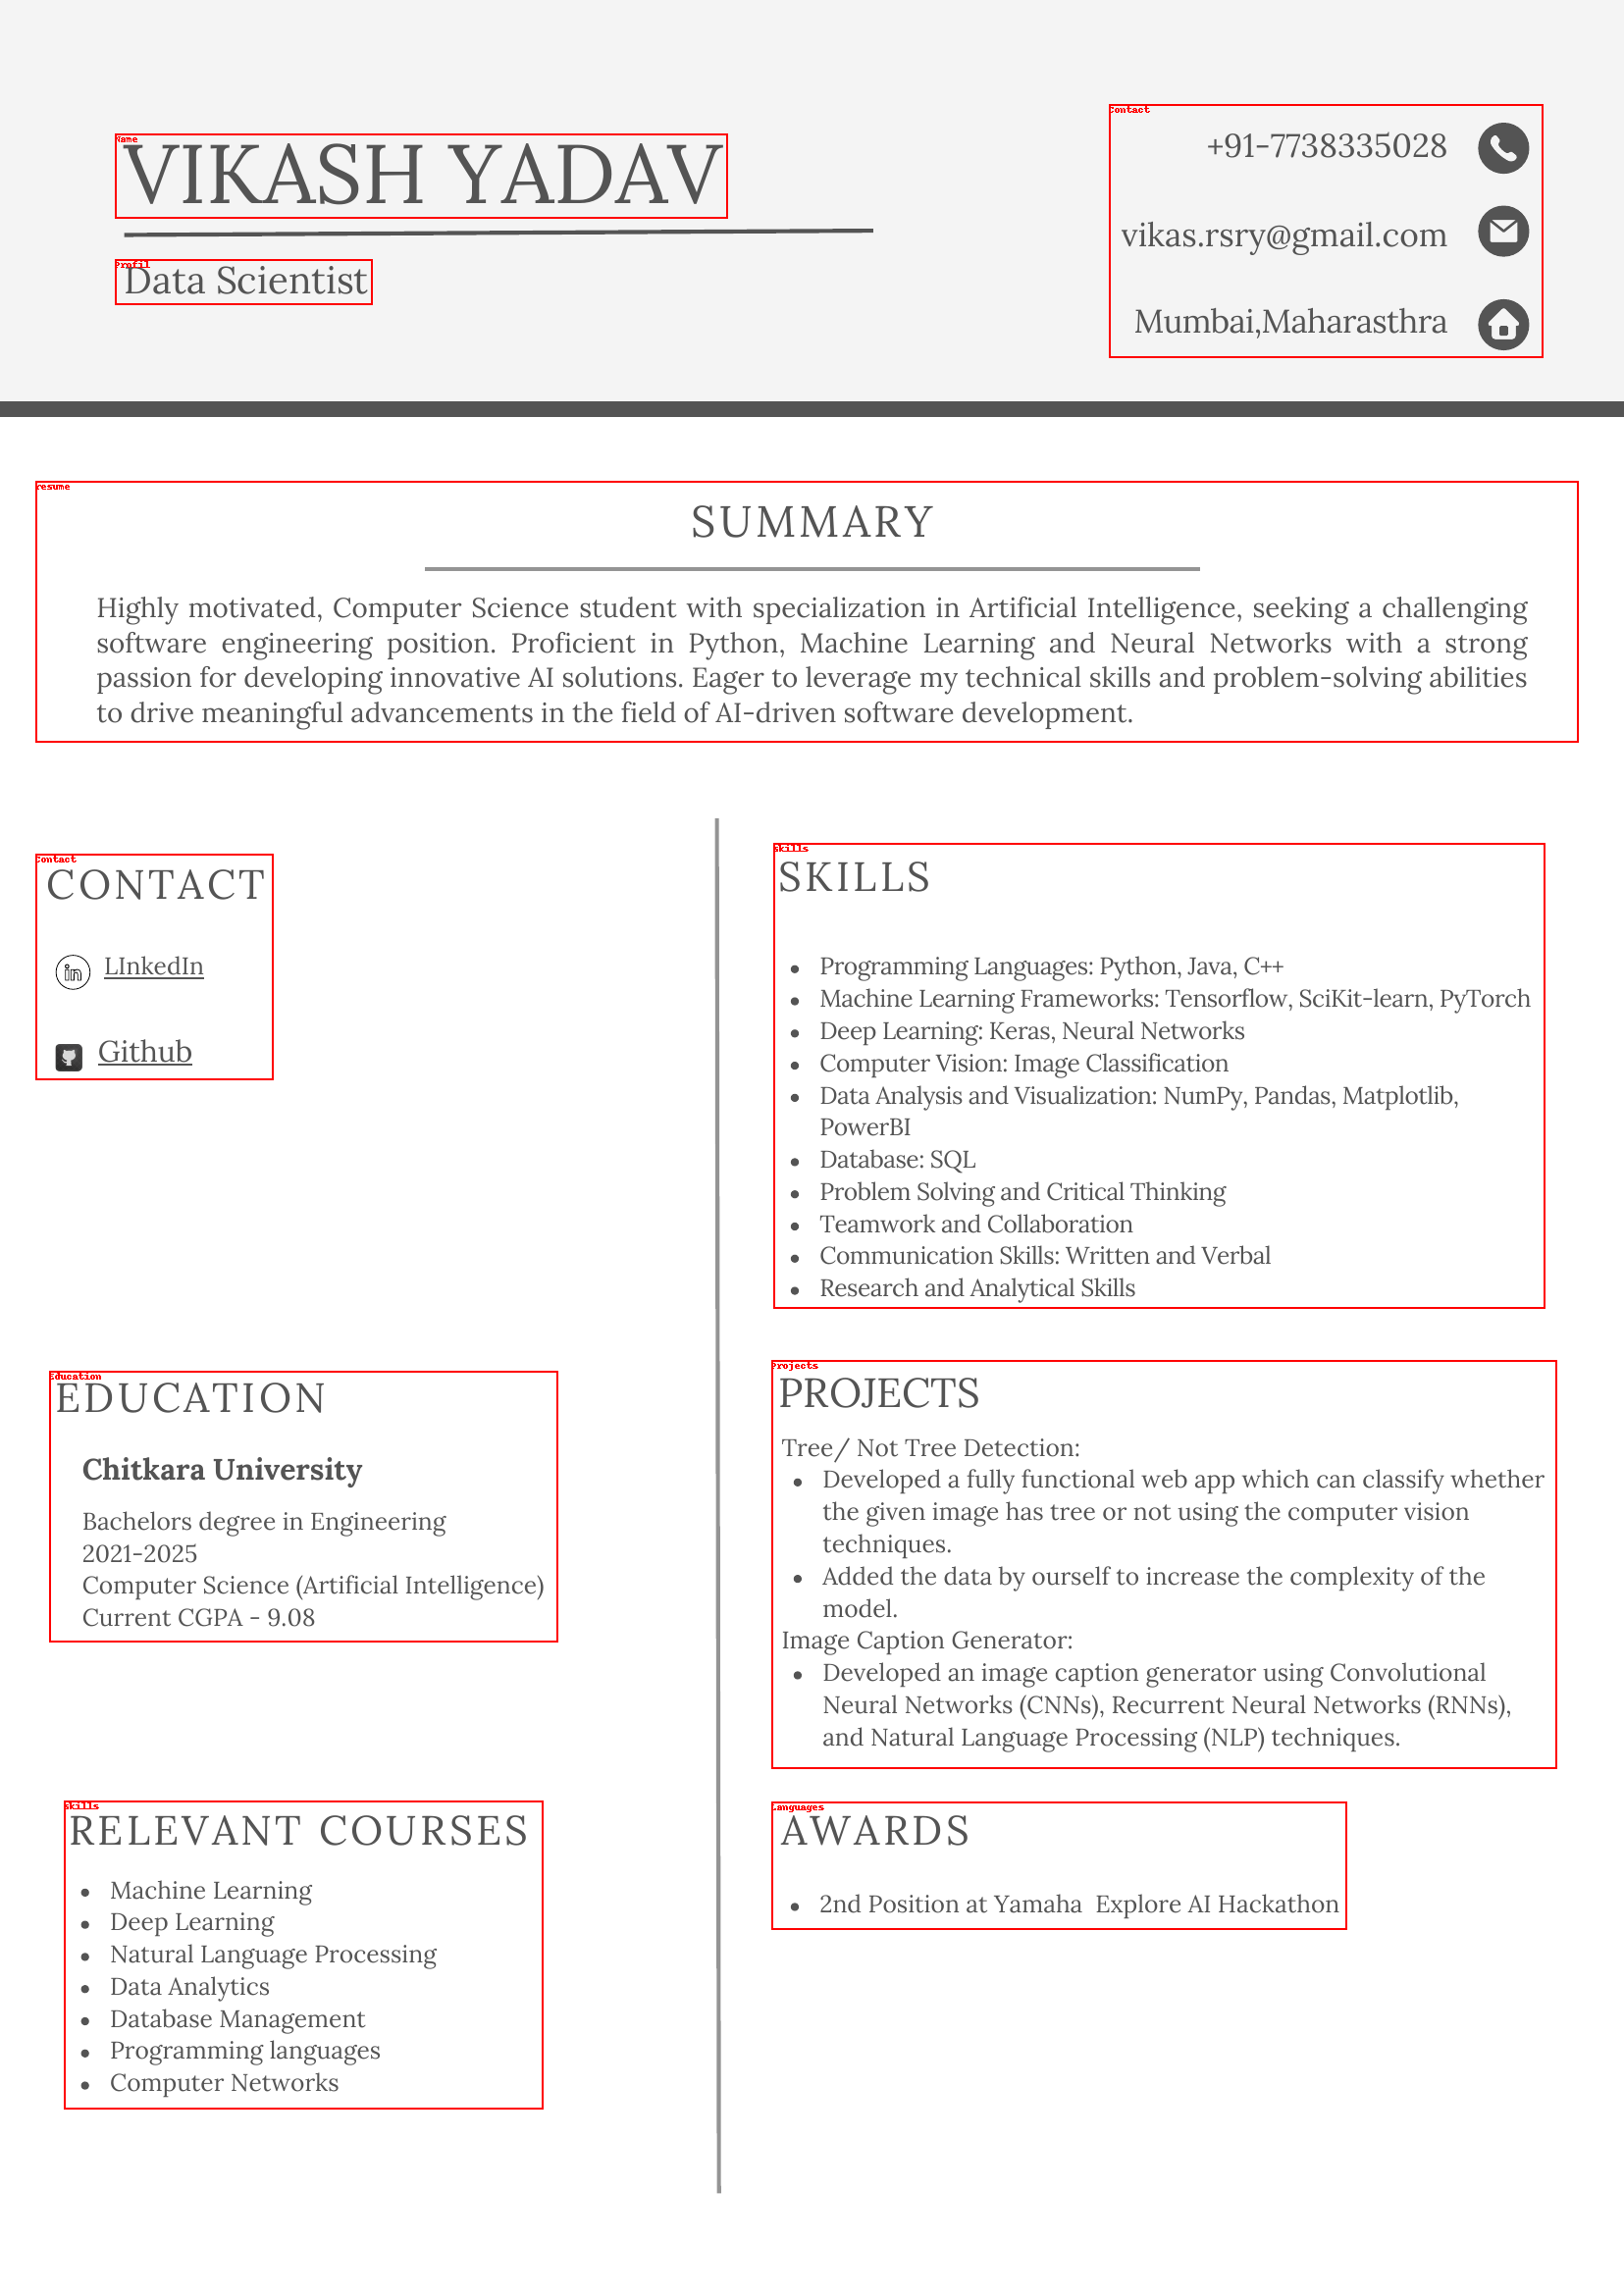

Education -  chitkara university  bachelors degree in engineering 2021-2025  computer science (artificial intelligence) current cgpa - 9.08 
skills - relevant courses  e machine learning  e deep learning  e natural language processing e data analytics  e database management  e programming languages  e computer networks 
resume - summary  highly motivated, computer science student with specialization in artificial intelligence, seeking a challenging software engineering position. proficient in python, machine learning and neural networks with a strong passion for developing innovative ai solutions. eager to leverage my technical skills and problem-solving abilities to drive meaningful advancements in the field of al-driven software development. 
Name - vikash yadav 
Contact - +91-7738335028 @ vikas.rsry@gmail.com 2  mumbai,maharasthra © 
Profil - data scientist 
Languages - awards  e 2nd position at yamaha explore al hackathon 
Projects -  tree/ not tree detection:  e developed a

In [ ]:
import os
import tempfile
from PIL import Image, ImageDraw
from pdf2image import convert_from_path
from roboflow import Roboflow
import pytesseract
import re

def apply_ocr(image):
    # Convert the image to grayscale
    gray_image = image.convert('L')

    # Use pytesseract to perform OCR
    text = pytesseract.image_to_string(gray_image)

    return text

def clean_ocr_text(ocr_text, class_name):
    # Remove newline characters
    cleaned_text = ocr_text.replace('\n', ' ')

    # Remove the class name if it appears at the beginning of the text
    cleaned_text = re.sub(fr'^{class_name.lower()} ', '', cleaned_text.lower())

    return cleaned_text

def extract_segments_with_ocr(pdf_path, model):
    # Convert each page of the PDF to an image
    images = convert_from_path(pdf_path)

    # Create a temporary directory to save the images
    with tempfile.TemporaryDirectory() as temp_dir:
        # Create a dictionary to store OCR results with labels
        ocr_results = {}

        # Iterate through each page's image
        for page_number, image in enumerate(images, start=1):
            # Save the image in the temporary directory
            image_path = os.path.join(temp_dir, f"page_{page_number}.png")
            image.save(image_path)

            # Create an ImageDraw object
            draw = ImageDraw.Draw(image)

            # Apply OCR to the page
            text = apply_ocr(image)

            # Get predictions using the model
            predictions = model.predict(image_path, confidence=40, overlap=30).json()

            # Create a dictionary to store OCR results with labels for the current page
            page_ocr_results = {}

            # Iterate through predictions and crop segments
            for prediction in predictions['predictions']:
                x, y, w, h = map(int, (prediction['x'], prediction['y'], prediction['width'], prediction['height']))

                # Ensure coordinates are within the image bounds
                x1 = max(0, x - w // 2)
                y1 = max(0, y - h // 2)
                x2 = min(image.width, x + w // 2)
                y2 = min(image.height, y + h // 2)

                # Crop the segment from the original image
                segment = image.crop((x1, y1, x2, y2))

                # Apply OCR to the segment
                text = apply_ocr(segment)

                # Use the 'class' provided in the predictions as the dictionary key
                class_label = prediction.get('class', 'Unknown')

                # Clean the OCR text
                cleaned_text = clean_ocr_text(text, class_label)

                # Store the cleaned text in the dictionary
                page_ocr_results[class_label] = cleaned_text

                # Draw the adjusted bounding box on the image with class label
                draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
                draw.text((x1, y1), class_label, fill="red")

            # Display the image with adjusted bounding boxes and labels
            display(image)

            # Display the cropped segments and their text for the current page
            for label, text in page_ocr_results.items():
                print(f"{label} - {text}")

            # Store the OCR results for the current page in the overall dictionary
            ocr_results[f"Page {page_number}"] = page_ocr_results

    return ocr_results
    import re

def extract_email_and_phone(contact_text):
    # Extract email using a simple regex pattern
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    emails = re.findall(email_pattern, contact_text)

    # Extract phone number using a regex pattern
    # This pattern captures phone numbers in the format: +xx-xxxxxxxxxx
    phone_pattern = r'\+\d{2}-\d{10}'
    phones = re.findall(phone_pattern, contact_text)

    return {'Email': emails, 'Phone': phones}

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def extract_skills(skill_text):
    # Remove special characters and split by whitespace
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', skill_text)

    # Split the text by whitespace
    skills_list = cleaned_text.split()

    # Remove stop words using NLTK
    stop_words = set(stopwords.words('english'))
    skills_list = [word for word in skills_list if word.lower() not in stop_words]

    # Combine pairs of words
    skills_list = [skills_list[i] + ' ' + skills_list[i+1] for i in range(0, len(skills_list), 2)]

    return skills_list

# Path to your local PDF file
pdf_path = "/content/vikas2.pdf"

# Call the function to extract segments with OCR and get the cleaned dictionary
result_dict = extract_segments_with_ocr(pdf_path, model)

# Print the resulting dictionary
print(result_dict)
# Assuming 'Page 1' is the relevant key in your dictionary
page_key = 'Page 1'
contact_text = result_dict[page_key].get('Contact', '')

# Extract email and phone from the 'Contact' text
contact_info = extract_email_and_phone(contact_text)

# Assuming 'Page 1' is the relevant key in your dictionary
page_key = 'Page 1'
skills_text = result_dict[page_key].get('skills', '')

# Extract skills using spaCy
skills_found = extract_skills(skills_text)

# Print the extracted skills
print(skills_found)


print(contact_info)

In [ ]:
!pip install PyMuPDF

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 28.5 MB/s eta 0:00:00


In [ ]:
!pip install pdf2image